In [1]:
#
#* 데이터 경로 설정
root_dir = !pwd
root_dir = root_dir[0]
# !mkdir -p data_demo
# %cd data_demo
# !gdown 1wjuiVcO92Rqer5gLk-X7hINfe4PCMQmu
# !pip install tqdm
# !unzip -o 5LpN3gDmAk7_1.zip | tqdm --desc extracted --unit files --unit_scale --total `unzip -l 5LpN3gDmAk7_1.zip | tail -n 1 | xargs echo -n | cut -d' ' -f2` > /dev/null
# %cd ..
import os
#data_dir = "/home/hong/capstone/vlmaps/data_custom"
data_dir = os.path.join(root_dir, "Data/habitat_sim/", "2t7WUuJeko7_2")
version = "inf3"
#
#* 갖고있는 depth, rgb 이미지를 이용해 비디오로 시각화해주는 작업
#* 단순 시각화용일 뿐이며, VLMaps 제작이나 이후 작업에 사용되지는 않음
# @title Helper functions for video creation and display
import sys
import os
import imageio
import numpy as np
import cv2
import tqdm
from IPython.display import HTML
from base64 import b64encode

# @markdown if the colab instance doesn't have GPU, untick the following checkbox
has_gpu = True # @param {type: "boolean"}
codec = "h264"
if has_gpu:
  codec = "h264_nvenc"

def load_depth(depth_filepath):
    with open(depth_filepath, 'rb') as f:
        depth = np.load(f)
    return depth


In [2]:
#
#* setup VLMaps parameters
# @markdown meters per cell size
cs = 0.025 # @param {type: "number"} #* 셀 크기 당 미터 단위
# @markdown map resolution (gs x gs)
gs = 2000 # @param {type: "integer"} #* 맵의 해상도 (그리드 수 _ 정수 단위)
# @markdown camera height (used for filtering out points on the floor)
camera_height = 1.5 # @param {type: "number"} #* 카메라 높이 (바닥에 있는 점을 필터링하는 데 사용)
# @markdown depth pixels subsample rate
depth_sample_rate = 10 # @param {type: "integer"} #* depth 정보의 픽셀 sampling rate
# @markdown data where rgb, depth, pose are loaded and map are saved
data_dir = data_dir # @param {type: "string"} #* 데이터 경로

In [3]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from utils.mapping_utils import load_map, get_new_pallete, get_new_mask_pallete
from utils.clip_utils import get_text_feats
from utils.matterport3d_categories import mp3dcat #* 여기엔 그 장애물이 리스트 형태로 저장되어있음
import clip

In [4]:
use_self_built_map = True # @param {type: "boolean"} 
map_save_dir = os.path.join(data_dir, "map")
if use_self_built_map:
    map_save_dir = os.path.join(data_dir, f"map/2t7WUuJeko7_2_{version}")
os.makedirs(map_save_dir, exist_ok=True)

color_top_down_save_path = os.path.join(map_save_dir, f"color_top_down_{version}.npy")
grid_save_path = os.path.join(map_save_dir, f"grid_{version}.npy")
obstacles_save_path = os.path.join(map_save_dir, f"obstacles_{version}.npy")
weight_save_path = os.path.join(map_save_dir, f"weight_{version}.npy")
background_grid_save_path = os.path.join(map_save_dir, f"background_grid_{version}.npy")
category_map_save_path = os.path.join(map_save_dir, f"category_map_{version}.npy")
instance_map_save_path = os.path.join(map_save_dir, f"instance_map_{version}.npy")
# gt_save_path = os.path.join(map_save_dir, f"grid_lseg_gt.npy")
print(data_dir)

/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/2t7WUuJeko7_2


[0 1]


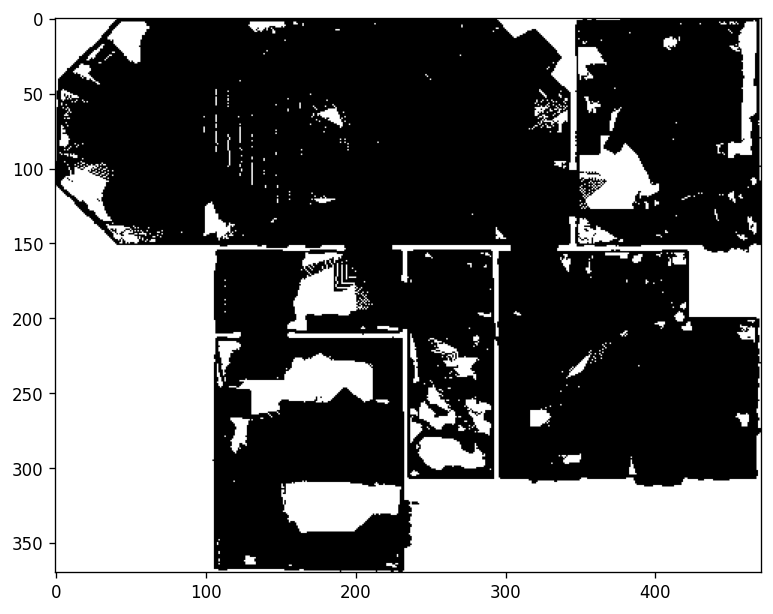

In [5]:
obstacles = load_map(obstacles_save_path)
color_top_down = load_map(color_top_down_save_path)
x_indices, y_indices = np.where(obstacles == 0)

xmin = np.min(x_indices)
xmax = np.max(x_indices)
ymin = np.min(y_indices)
ymax = np.max(y_indices)

print(np.unique(obstacles))
obstacles_pil = Image.fromarray(obstacles[xmin:xmax+1, ymin:ymax+1])
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(obstacles_pil, cmap='gray')
plt.show()

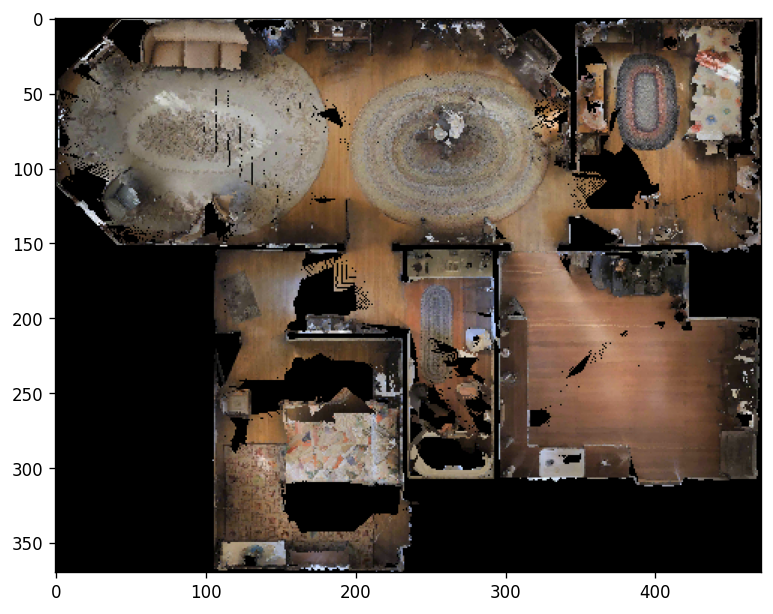

In [6]:
color_top_down = load_map(color_top_down_save_path)
color_top_down = color_top_down[xmin:xmax+1, ymin:ymax+1]
color_top_down_pil = Image.fromarray(color_top_down)
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(color_top_down_pil)
plt.show()

In [7]:
%%capture
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
grid = load_map(grid_save_path)
print(grid.shape)
grid = grid[xmin:xmax+1, ymin:ymax+1]
print(grid.shape)
print(grid_save_path)
print(grid[100,100].keys())

(2000, 2000)
(370, 471)
/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/2t7WUuJeko7_2/map/2t7WUuJeko7_2_inf3/grid_inf3.npy
dict_keys([2113])


In [9]:
# background_grid = load_map(background_grid_save_path)
# background_grid = background_grid[xmin:xmax+1, ymin:ymax+1]
# print(background_grid.shape)
# bbackground_grid = np.zeros_like(background_grid)
# bbackground_grid[background_grid == 1] = 2
# bbackground_grid[background_grid == 2] = 1

In [10]:
from seem.base_model import build_vl_model
model = build_vl_model("seem", input_size = 360)

[*] model loaded


In [11]:
# query = ["void","table in the kitchen"]
query = [
    "void",
    "wall",
    "floor",
    "chair",
    "door",
    "table",
    "picture",
    "cabinet",
    "cushion",
    "window",
    "sofa",
    "bed",
    "curtain",
    "chest_of_drawers",
    "plant",
    "sink",
    "stairs",
    "ceiling",
    "toilet",
    "stool",
    "towel",
    "mirror",
    "tv_monitor",
    "shower",
    "column",
    "bathtub",
    "counter",
    "fireplace",
    "lighting",
    "beam",
    "railing",
    "shelving",
    "blinds",
    "gym_equipment",
    "seating",
    "board_panel",
    "furniture",
    "appliances",
    "clothes",
    "objects",
    # "carpet"
]
# query = [
#     "void",
#     "wall",
#     "floor",
#     "chair",
#     "door",
#     "table",
#     "picture",
#     "cabinet",
#     "cushion",
#     "window",
#     "sofa",
#     "bed",
#     "curtain",
#     "sink",
#     "stairs"
# ]

# query = [
#     "void",
# #    "floor",
#     "bed_room in a scene"
# ]
t_emb = model.encode_prompt(query, task="default")

aa = t_emb.cpu().numpy()
print(aa.shape)

# query = ["table","computer"]
# t_emb = model.encode_prompt(query, task="default")
# aa = t_emb.cpu().numpy()

# print(aa.shape)

# qq = ["computer on the table"]
# tt = model.encode_prompt(qq, task="default")
# bb = tt.cpu().numpy()



(40, 512)


In [12]:
import pickle

embeddings_path = os.path.join(map_save_dir, f"instance_dict_{version}.pkl")

print(embeddings_path)



#"/home/hong/VLMAPS/vlseem/Data/habitat/vlmaps_dataset/2t7WUuJeko7_2_mini/map/instance_dict_dummy_geo_dist4.pkl"

with open(embeddings_path, 'rb') as f:
    embeddings = pickle.load(f)

no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0

/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/2t7WUuJeko7_2/map/2t7WUuJeko7_2_inf3/instance_dict_inf3.pkl


(370, 471)
embeddings: 153


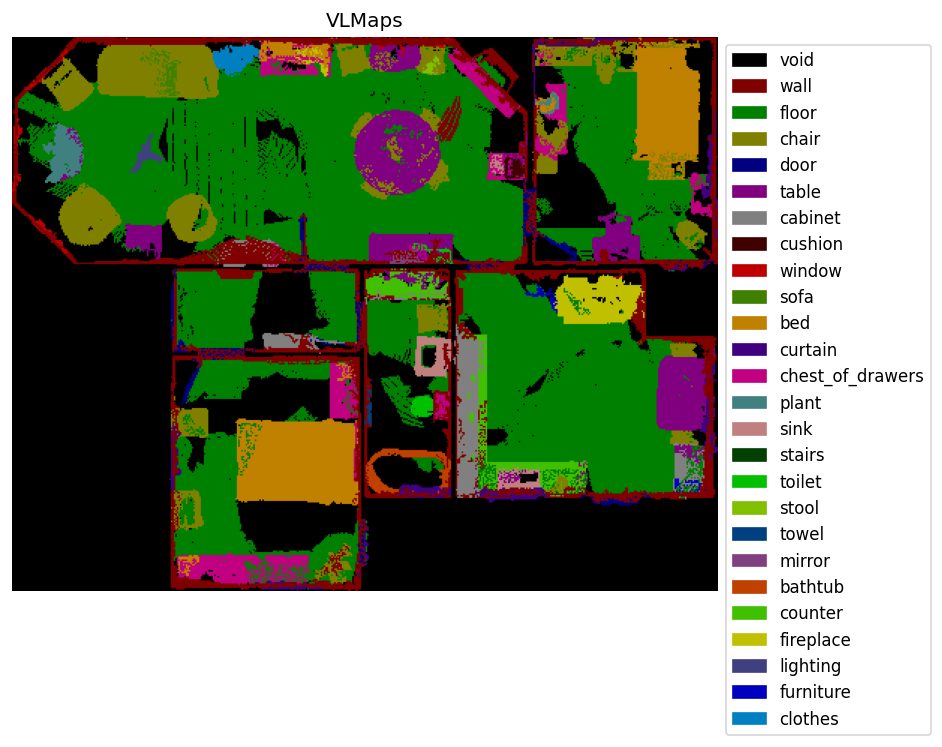

In [13]:
no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0
print(grid.shape)
id_list = []
instance_feat = []
print("embeddings:",len(embeddings.keys()))
# print(embeddings.keys())
# print("grid:",grid.shape)
ids=[]
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        for arg in grid[i,j].keys():
            if arg not in ids:
                ids.append(arg)

# np.set_printoptions(threshold=np.inf)
# print(ids)
# print("grid ids:",len(ids))
# print(grid)
# print(embeddings)
for id, val in embeddings.items():
    id_list.append(id)
    instance_feat.append(val["embedding"])
instance_feat = np.array(instance_feat)

# instance_feat = np.vstack([aa[:2,:],instance_feat])

# print("instance_feat:",instance_feat.shape)
scores_list = instance_feat @ aa.T
# print("scores_list:",scores_list)
# key_list = list(embeddings.keys())
# print(key_list)
# print(scores_list.shape)
predicts = np.argmax(scores_list, axis=1)
ggrid_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
# ggrid_map[background_grid == 1] = 2
# ggrid_map[background_grid == 2] = 1
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if len(grid[i,j].keys()) == 0:
            continue
        if len(grid[i,j].keys()) == 1:
            # print(grid[i,j][0])
            for key in grid[i,j].keys():
                # if key in [1,0]:
                #     ggrid_map[i,j]=key
                #     continue
                ggrid_map[i,j] = predicts[list(embeddings.keys()).index(key)]
        else:
            max_conf = 0
            max_height = 50000
            max_observed = 0
            for key, val in grid[i,j].items():
                # print(arg)
                # print(predicts.shape)
                # if key in [1,0]: continue
                candidate = predicts[list(embeddings.keys()).index(key)]
                candidate_conf = val[0]
                candidate_height = val[1]
                candidate_observed = val[2]
                # if max_conf < candidate_conf:
                #     max_conf = candidate_conf
                #     candidate_val = candidate
                if max_height > candidate_height:
                    max_height = candidate_height
                    candidate_val = candidate
                # if candidate_observed > max_observed:
                #     max_observed = candidate_observed
                #     candidate_val = candidate
            ggrid_map[i,j] = candidate_val
floor_mask = ggrid_map == 2
# print("ggrid_map",ggrid_map.shape)
new_pallete = get_new_pallete(len(query))
mask, patches = get_new_mask_pallete(ggrid_map, new_pallete, out_label_flag=True, labels=query)
seg = mask.convert("RGBA")
seg = np.array(seg)
# seg[no_map_mask] = [225, 225, 225, 255]
# seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)



# ggrid_map_save_path = os.path.join(map_save_dir, f"ggrid_{mask_version}.npy")
# np.save(ggrid_map_save_path, ggrid_map)

plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.show()

(370, 471)
embeddings: 153


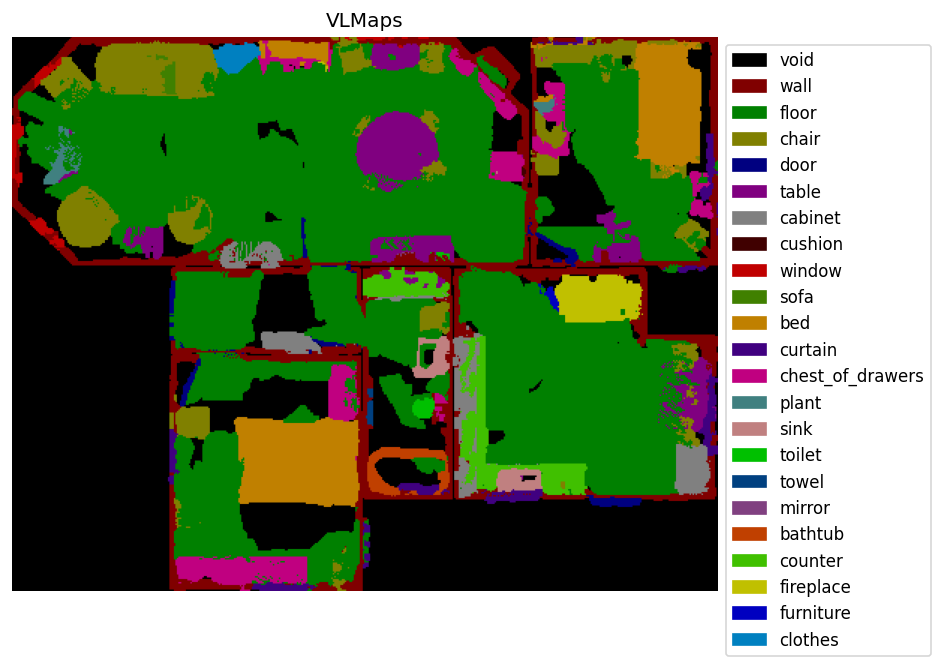

In [14]:
no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0
print(grid.shape)
id_list = []
instance_feat = []
print("embeddings:",len(embeddings.keys()))
# print(embeddings.keys())
# print("grid:",grid.shape)
ids=[]
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        for arg in grid[i,j].keys():
            if arg not in ids:
                ids.append(arg)

# np.set_printoptions(threshold=np.inf)
# print(ids)
# print("grid ids:",len(ids))
# print(grid)
# print(embeddings)
for id, val in embeddings.items():
    id_list.append(id)
    instance_feat.append(val["embedding"])
instance_feat = np.array(instance_feat)
# print("instance_feat:",instance_feat.shape)
scores_list = instance_feat @ aa.T
# print("scores_list:",scores_list)
# key_list = list(embeddings.keys())
# print(key_list)
# print(scores_list.shape)
predicts = np.argmax(scores_list, axis=1)
ggrid_map = np.empty_like(grid, dtype=dict)
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        ggrid_map[i,j] = {}
        
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if len(grid[i,j].keys()) == 0:
            continue
        # if len(grid[i,j].keys()) == 1:
        #     # print(grid[i,j][0])
        for key in grid[i,j].keys():
            new_key = predicts[list(embeddings.keys()).index(key)]
            ggrid_map[i,j][new_key] = grid[i,j][key][2]
                # ggrid_map[i,j] = predicts[list(embeddings.keys()).index(key)]
        # else:
        #     max_conf = 0
        #     max_height = 0
        #     # candidate_val = 0
        #     for key, val in grid[i,j].items():
        #         # print(arg)
        #         # print(predicts.shape)
        #         candidate = predicts[list(embeddings.keys()).index(key)]
        #         candidate_conf = val[0]
        #         candidate_height = val[2]
        #         # if max_conf < candidate_conf:
        #         #     max_conf = candidate_conf
        #         #     candidate_val = candidate
        #         if max_height < candidate_height:
        #             max_height = candidate_height
        #             candidate_val = candidate
        #     ggrid_map[i,j] = candidate_val

center_weight = 3
gggrid_map = np.zeros_like(ggrid_map, dtype=np.uint8)
grid_upper = np.empty((ggrid_map.shape[0]+1, ggrid_map.shape[1]+1), dtype=dict)
for i in range(ggrid_map.shape[0]+1):
    for j in range(ggrid_map.shape[1]+1):
        grid_upper[i,j] = {}
grid_upper[1:,1:] = ggrid_map
for i in range(1,gggrid_map.shape[0]+1):
    for j in range(1,gggrid_map.shape[1]+1):
        candidate = grid_upper[i-1:i+2,j-1:j+2]
        item_dict = {}
        for candidate_i in range(candidate.shape[0]):
            for candidate_j in range(candidate.shape[1]):
                if candidate_i == i and candidate_j == j:
                    # if len(candidate[candidate_i,candidate_j]) == 0: continue
                    for key, val in candidate[candidate_i,candidate_j].items():
                        if key in item_dict.keys():
                            item_dict[key] += center_weight #* val
                        else: item_dict[key] = center_weight #* val
                else:
                    # if len(candidate[candidate_i,candidate_j]) == 0: continue
                    for key, val in candidate[candidate_i,candidate_j].items():
                        if key in item_dict.keys():
                            item_dict[key] += 1 #* val
                        else: item_dict[key] = 1 #*  val
        if len(item_dict) ==0:
            gggrid_map[i-1,j-1] = 0
            continue
        max_key = max(item_dict, key=item_dict.get)
        gggrid_map[i-1,j-1] = max_key


floor_mask = gggrid_map == 2
# print("ggrid_map",ggrid_map.shape)
new_pallete = get_new_pallete(len(query))
mask, patches = get_new_mask_pallete(gggrid_map, new_pallete, out_label_flag=True, labels=query)
seg = mask.convert("RGBA")
seg = np.array(seg)
# seg[no_map_mask] = [225, 225, 225, 255]
# seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)
plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.show()

In [15]:
category_map = load_map(category_map_save_path)
no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0
print(grid.shape)
id_list = []
instance_feat = []
print("embeddings:",len(embeddings.keys()))
# print(embeddings.keys())
# print("grid:",grid.shape)
ids=[]
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        for arg in grid[i,j].keys():
            if arg not in ids:
                ids.append(arg)

# np.set_printoptions(threshold=np.inf)
# print(ids)
# print("grid ids:",len(ids))
# print(grid)
# print(embeddings)
for id, val in embeddings.items():
    id_list.append(id)
    instance_feat.append(val["embedding"])
instance_feat = np.array(instance_feat)

# instance_feat = np.vstack([aa[:2,:],instance_feat])

# print("instance_feat:",instance_feat.shape)
scores_list = instance_feat @ aa.T
# print("scores_list:",scores_list)
# key_list = list(embeddings.keys())
# print(key_list)
# print(scores_list.shape)
predicts = np.argmax(scores_list, axis=1)
ggrid_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
# ggrid_map[background_grid == 1] = 2
# ggrid_map[background_grid == 2] = 1
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if len(grid[i,j].keys()) == 0:
            continue
        if len(grid[i,j].keys()) == 1:
            # print(grid[i,j][0])
            for key in grid[i,j].keys():
                # if key in [1,0]:
                #     ggrid_map[i,j]=key
                #     continue
                ggrid_map[i,j] = predicts[list(embeddings.keys()).index(key)]
        else:
            max_conf = 0
            max_height = 50000
            max_observed = 0
            for key, val in grid[i,j].items():
                # print(arg)
                # print(predicts.shape)
                # if key in [1,0]: continue
                candidate = predicts[list(embeddings.keys()).index(key)]
                candidate_conf = val[0]
                candidate_height = val[1]
                candidate_observed = val[2]
                # if max_conf < candidate_conf:
                #     max_conf = candidate_conf
                #     candidate_val = candidate
                # if max_height > candidate_height:
                #     max_height = candidate_height
                #     candidate_val = candidate
                if candidate_observed > max_observed:
                    max_observed = candidate_observed
                    candidate_val = candidate
            ggrid_map[i,j] = candidate_val
floor_mask = ggrid_map == 2
# print("ggrid_map",ggrid_map.shape)
new_pallete = get_new_pallete(len(query))
mask, patches = get_new_mask_pallete(category_map, new_pallete, out_label_flag=True, labels=query)
seg = mask.convert("RGBA")
seg = np.array(seg)
# seg[no_map_mask] = [225, 225, 225, 255]
# seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)



# ggrid_map_save_path = os.path.join(map_save_dir, f"ggrid_{mask_version}.npy")
# np.save(ggrid_map_save_path, ggrid_map)

plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/2t7WUuJeko7_2/map/2t7WUuJeko7_2_inf3/category_map_inf3.npy'

18


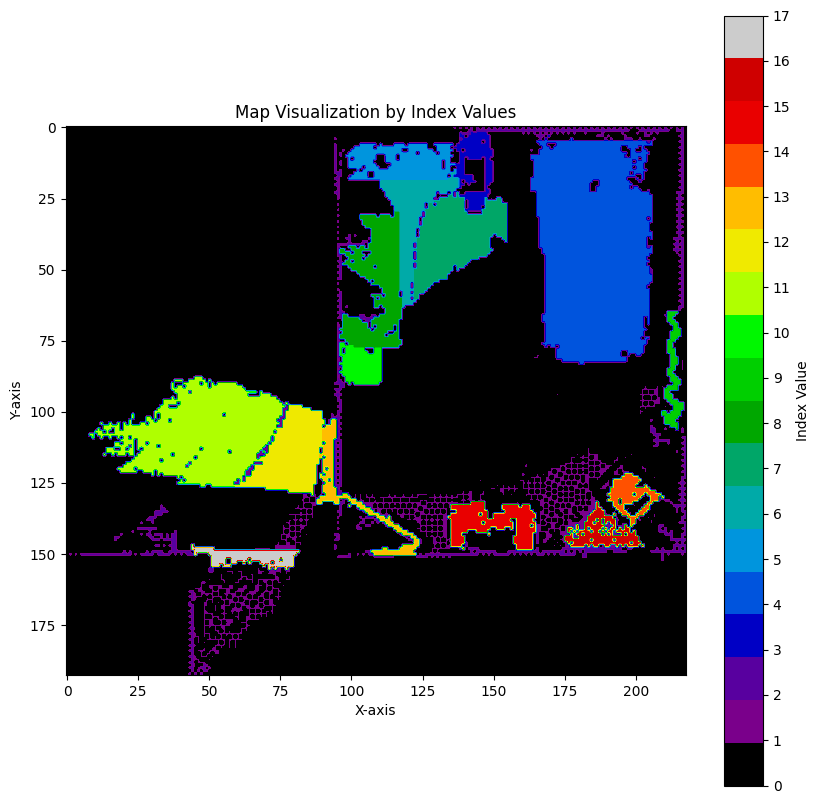

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

instance_map = load_map(instance_map_save_path)

# unique한 인스턴스 인덱스 값을 가져옴
unique_indices = np.unique(instance_map)
print(len(unique_indices))
num_colors = len(unique_indices)

# 임의의 색상 리스트 생성
colors = plt.cm.nipy_spectral(np.linspace(0, 1, num_colors))
cmap = ListedColormap(colors)

# 인덱스 값이 각 고유 인덱스에 매핑되도록 색상 매핑
index_to_color = {idx: i for i, idx in enumerate(unique_indices)}
colored_map = np.vectorize(index_to_color.get)(instance_map)

# 시각화
plt.figure(figsize=(10, 10))
plt.imshow(colored_map, cmap=cmap)  
plt.colorbar(ticks=range(num_colors), label='Index Value')  # 고유한 색상 바 추가
plt.title('Map Visualization by Index Values')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


In [17]:
import numpy as np

if np.all((instance_map == 1) == (category_map == 2)):
    print("same")


In [18]:
for id in np.unique(instance_map):
    if id ==0:continue
    ha = np.zeros_like(instance_map)
    ha[instance_map == id] = 1

    plt.clf()  # 이전 이미지 지우기
    # name = predicts[id-1]
    # print(query[name])
    print(ha.shape)
    print(np.sum(ha))
    plt.imshow(ha, cmap="gray")


    plt.axis('off')
    plt.title(f"Points with Key {id}")
    plt.draw()  # 현재 상태를 그리기
    plt.pause(0.5)  # 0.5초 간격으로 업데이트 (시간 조정 가능)

    plt.show()

NameError: name 'instance_map' is not defined

In [24]:
temp1 = 199
temp2 = 196

temp1_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
temp2_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
# temp1_feat = instance_feat[temp1]

temp1_feat = embeddings[temp1]["embedding"]
temp1_mask = embeddings[temp1]["mask"]
temp1_feat = temp1_feat / np.linalg.norm(temp1_feat)
# temp2_feat = instance_feat[temp2]
temp2_feat = embeddings[temp2]["embedding"]
temp2_mask = embeddings[temp2]["mask"]
temp2_feat = temp2_feat / np.linalg.norm(temp2_feat)


print(f"Size: {np.sum(temp1_mask)} {np.sum(temp2_mask)}")


semSim = temp1_feat @ temp2_feat.T
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if temp1 in grid[i,j]:
            temp1_map[i,j] = 1
        if temp2 in grid[i,j]:
            temp2_map[i,j] = 1
print(f"size2: {np.sum(temp1_map)} {np.sum(temp2_map)}")
union_map = np.logical_or(temp1_map, temp2_map).astype(int)
intersection_map = np.logical_and(temp1_map, temp2_map).astype(int)

uu=np.logical_or(temp1_mask, temp2_mask).astype(int)
ii=np.logical_and(temp1_mask, temp2_mask).astype(int)
iiou = np.sum(ii) / np.sum(uu)
print(f"IIoU: {iiou:.3f} (for checking the mask is correct)")


iou = np.sum(intersection_map) / np.sum(union_map)


temp1_center = np.argwhere(temp1_map == 1).mean(axis=0)
temp2_center = np.argwhere(temp2_map == 1).mean(axis=0)
center_dist = np.linalg.norm(temp1_center - temp2_center)

# temp1_bbox = calculate_bbox(temp1_map)
# temp2_bbox = calculate_bbox(temp2_map)
# iou_bbox = calculate_iou_bbox(temp1_bbox, temp2_bbox)


print(f"Center Point : temp1 {temp1_center}, temp2 {temp2_center}")
# print(f"bbox IoU: {iou_bbox:.3f}")
print(f"IoU: {iou:.3f}, Center Distance: {center_dist:.3f}")
print(f"Cosine Similarity: {semSim}")

contours1, _ = cv2.findContours(temp1_map.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours2, _ = cv2.findContours(temp2_map.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


lengths1 = [len(contour) for contour in contours1]
if len(contours1) == 0:
    raise Exception("no contour")
contour1 = contours1[np.argmax(lengths1)].squeeze(axis=1)
lengths2 = [len(contour) for contour in contours2]
contour2 = contours2[np.argmax(lengths2)].squeeze(axis=1)
haus12 = directed_hausdorff(contour1, contour2)[0]
haus21 = directed_hausdorff(contour2, contour1)[0]
hausdorff_distance = (haus12 + haus21) / 2
print(f"Hausdorff Distance: {hausdorff_distance}")

Size: 2210 2506
size2: 2210 2506
IIoU: 0.862 (for checking the mask is correct)
Center Point : temp1 [ 78.01628959 257.75158371], temp2 [ 77.12729449 256.32003192]
IoU: 0.862, Center Distance: 1.685
Cosine Similarity: 0.9979298114776611


NameError: name 'directed_hausdorff' is not defined

dict_keys([0, 1, 2, 8, 12, 18, 35, 39, 51, 73, 76, 85, 86, 88, 105, 107, 111, 119, 240, 247, 254, 263, 332, 367, 380, 390, 392, 486, 490, 579, 611, 633, 648, 650, 695, 697, 718, 722, 824, 852, 988, 990, 1010, 1013, 1069, 1117, 1121, 1125, 1152, 1155, 1164, 1171, 1176, 1196, 1206, 1242, 1245, 1256, 1274, 1392, 1426, 1585, 1598, 1636, 2013, 2491, 2601, 2799, 2902, 3010, 3555, 3603, 3806, 3829, 3839, 3926, 3931, 3936, 3937, 3944, 3945, 3956, 3960, 3964, 3965, 3969, 3977, 3987, 3996, 3997, 4002, 4004, 4046, 4049, 4072, 4311, 4463, 4466, 4549, 4587, 4605, 4645, 4680, 4734, 4904, 4928, 4958, 4981, 5293, 5300, 5522, 5556, 5578, 5594, 5605, 5606, 5612, 5624, 5630, 5710, 5775, 5777, 5835, 5836, 5844, 5847, 5912, 5921, 5927, 5962, 5983, 5990, 6013, 6050, 6062, 6110, 6119, 6125, 6216, 6316, 6321, 6356, 6426, 6892, 6915, 6985, 6992, 7071, 7190, 7656, 7705, 7734, 7811])
wall
(370, 471)
15260


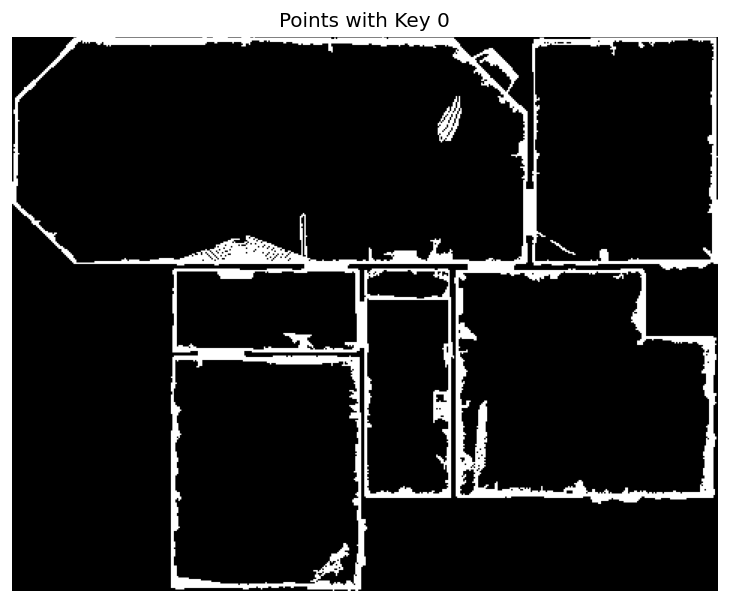

floor
(370, 471)
55147


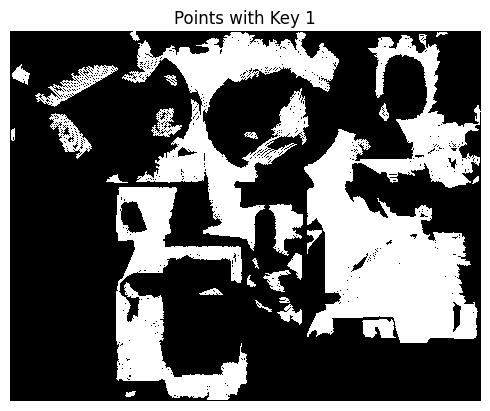

bed
(370, 471)
3460


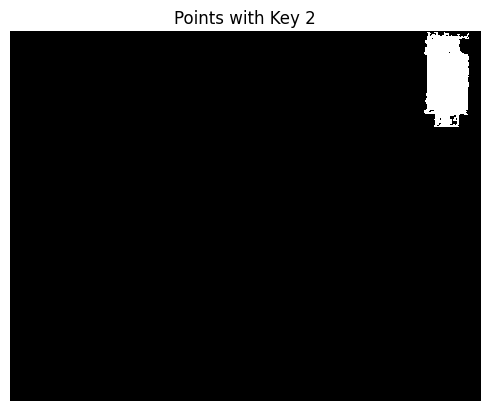

bed
(370, 471)
175


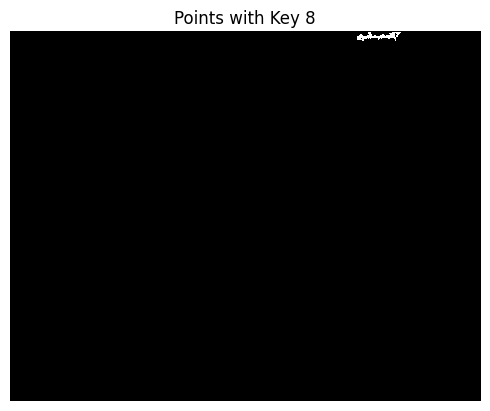

curtain
(370, 471)
205


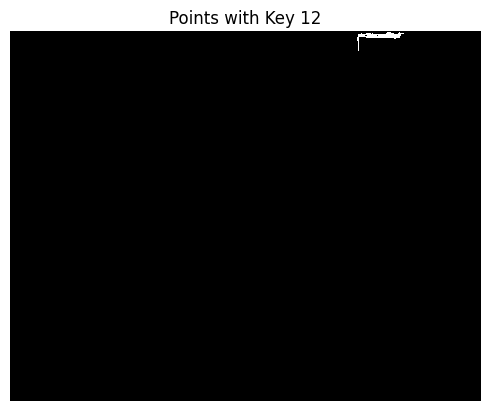

curtain
(370, 471)
316


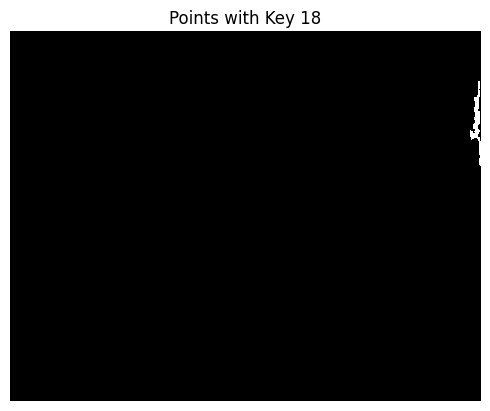

chair
(370, 471)
244


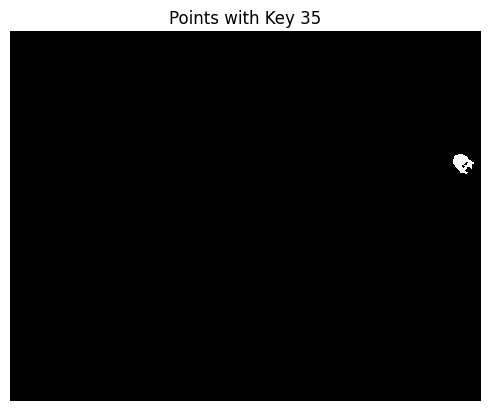

table
(370, 471)
726


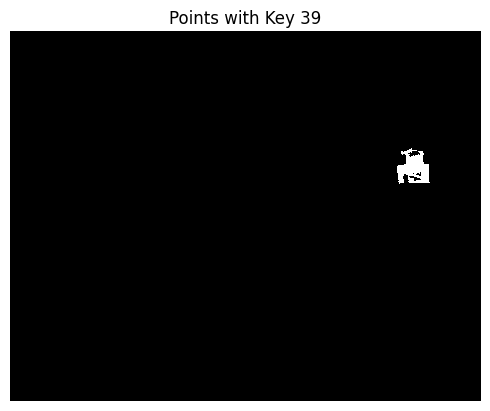

door
(370, 471)
127


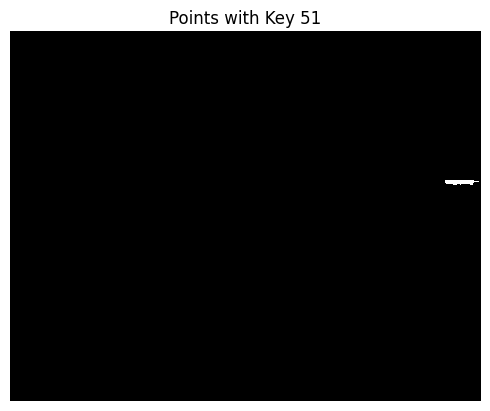

chair
(370, 471)
512


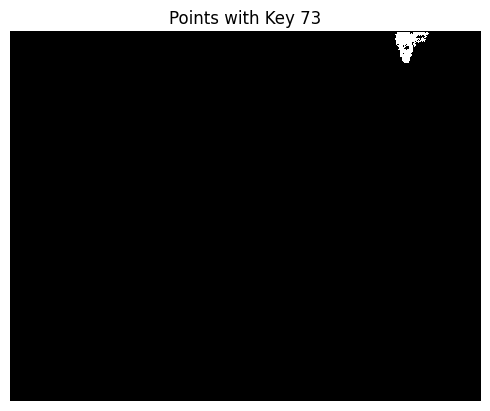

chair
(370, 471)
643


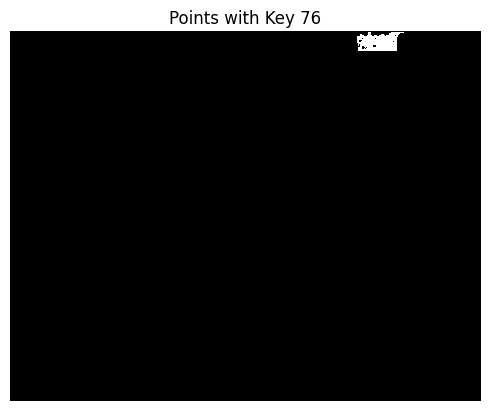

floor
(370, 471)
2533


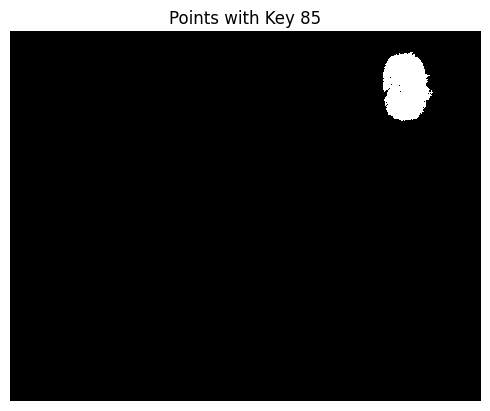

chest_of_drawers
(370, 471)
592


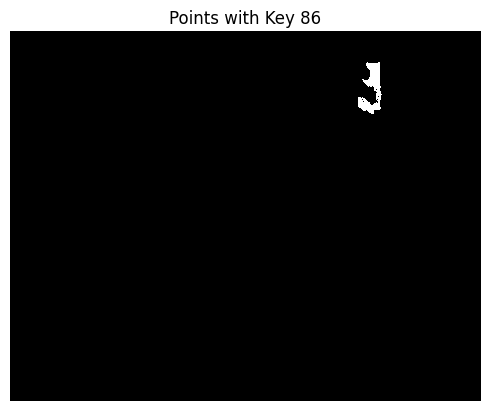

plant
(370, 471)
168


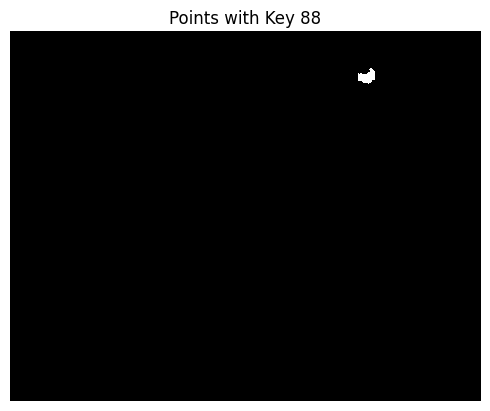

chair
(370, 471)
220


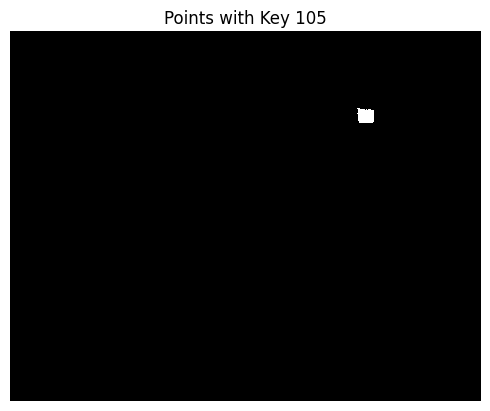

floor
(370, 471)
11364


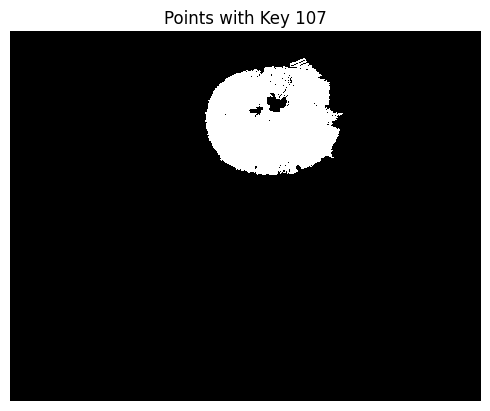

chair
(370, 471)
330


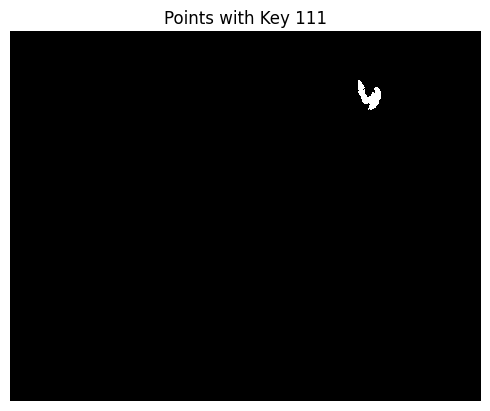

door
(370, 471)
455


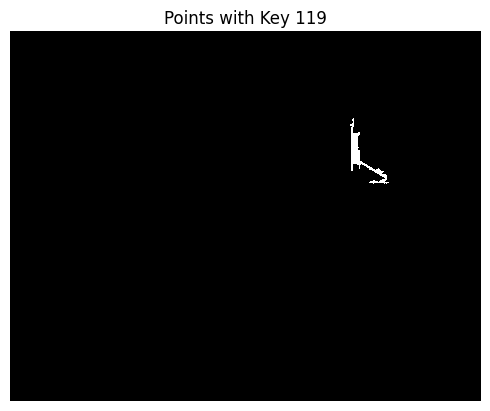

chest_of_drawers
(370, 471)
101


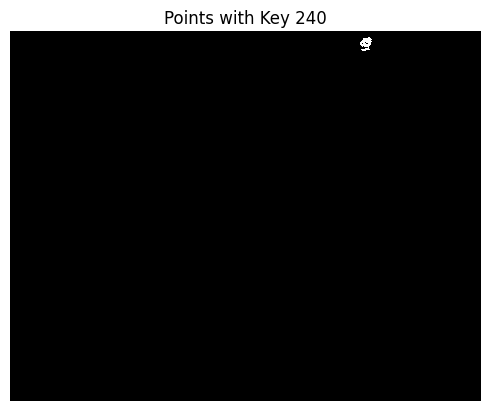

bed
(370, 471)
139


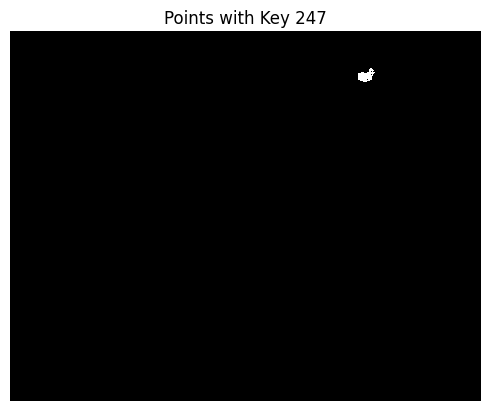

curtain
(370, 471)
203


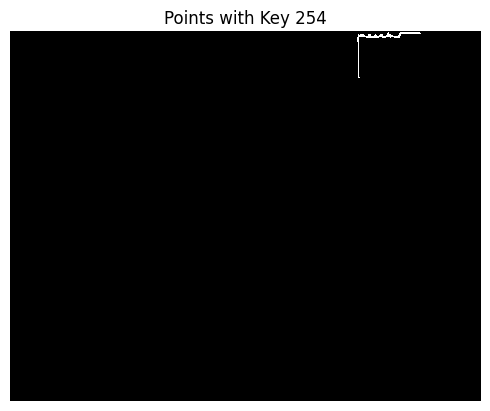

chair
(370, 471)
173


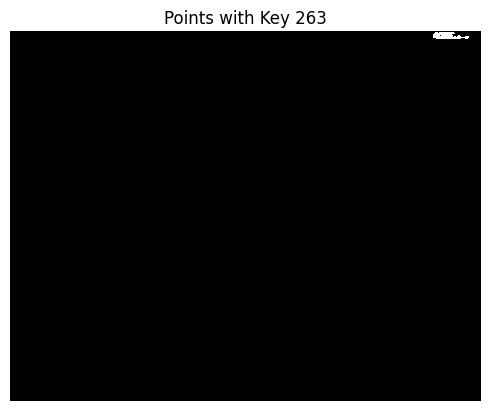

curtain
(370, 471)
101


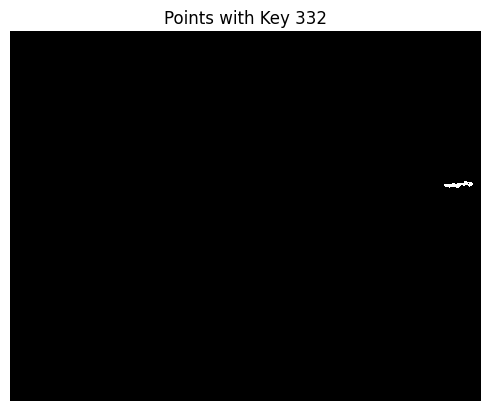

table
(370, 471)
1108


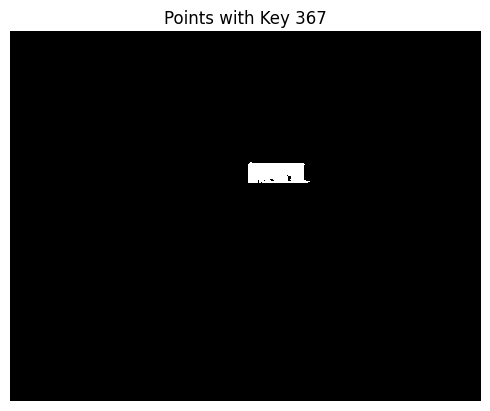

toilet
(370, 471)
157


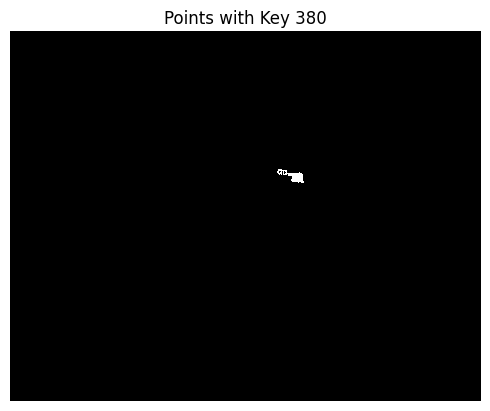

table
(370, 471)
2533


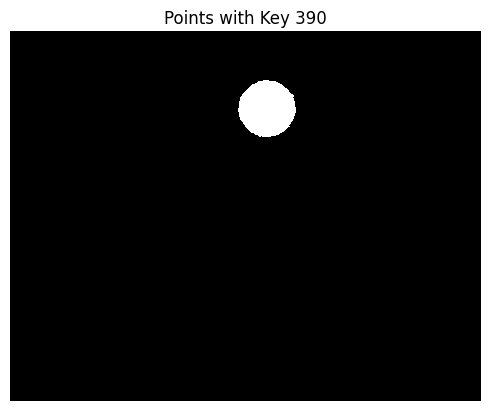

chair
(370, 471)
360


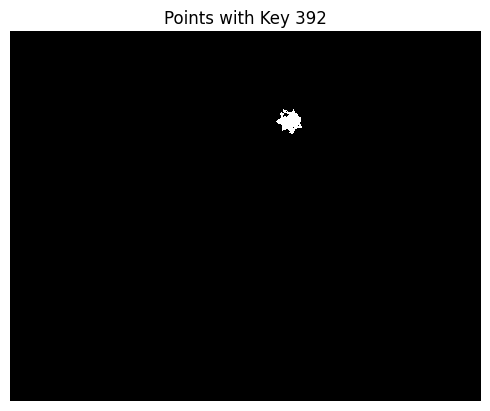

chair
(370, 471)
105


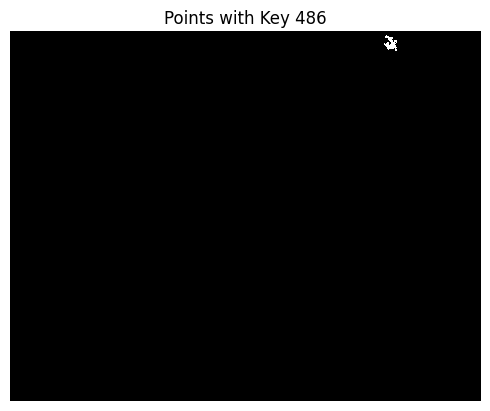

chest_of_drawers
(370, 471)
275


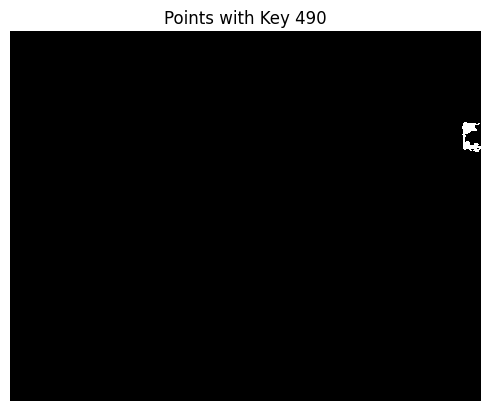

mirror
(370, 471)
151


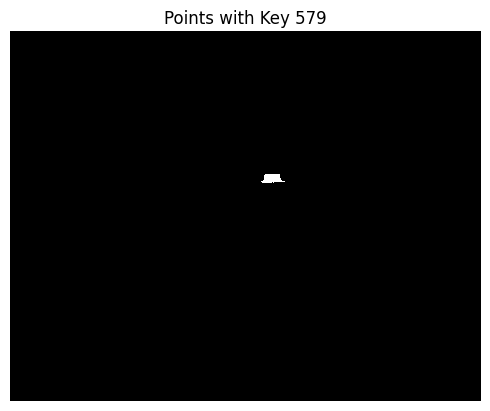

chair
(370, 471)
456


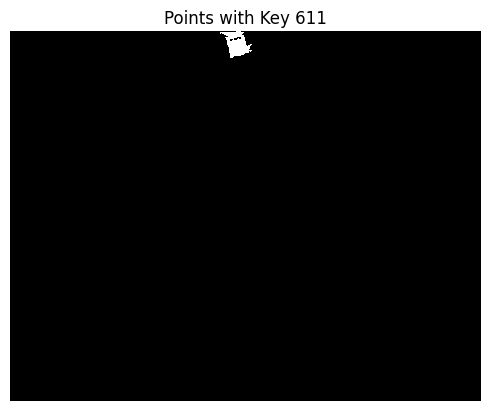

window
(370, 471)
354


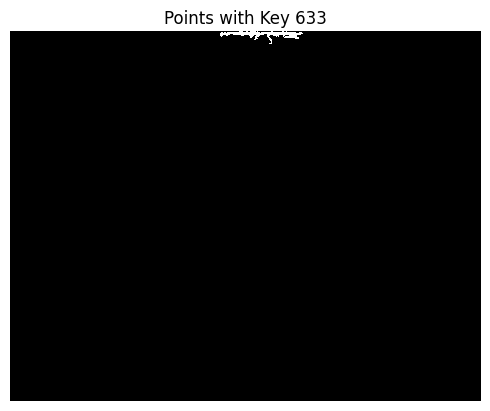

floor
(370, 471)
400


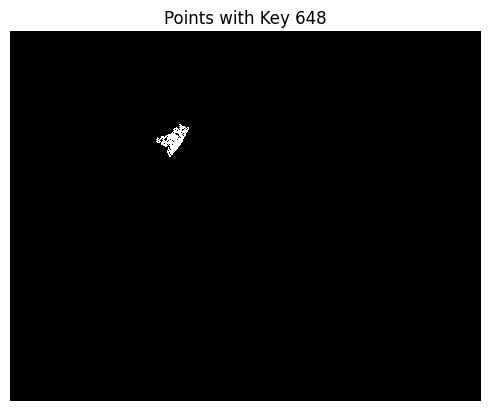

chair
(370, 471)
411


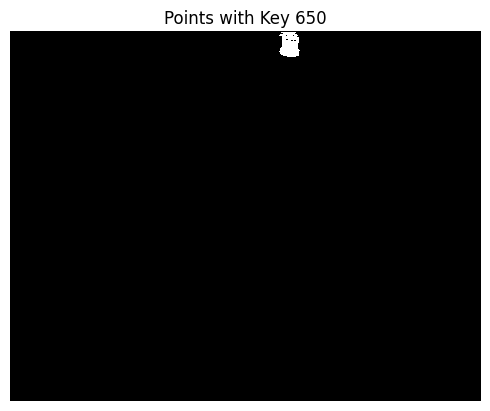

chest_of_drawers
(370, 471)
426


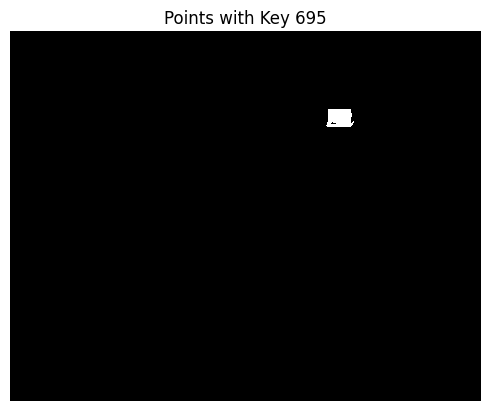

table
(370, 471)
620


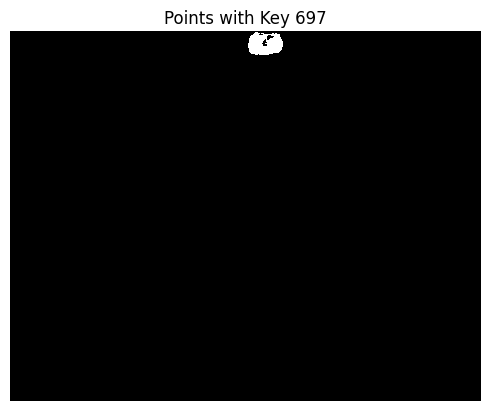

chair
(370, 471)
344


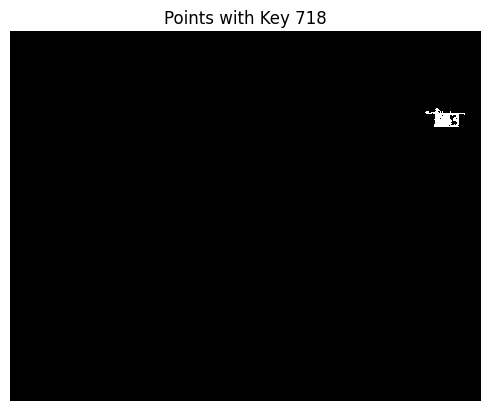

chest_of_drawers
(370, 471)
646


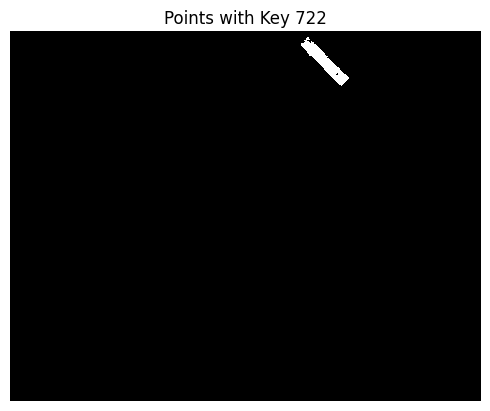

cushion
(370, 471)
173


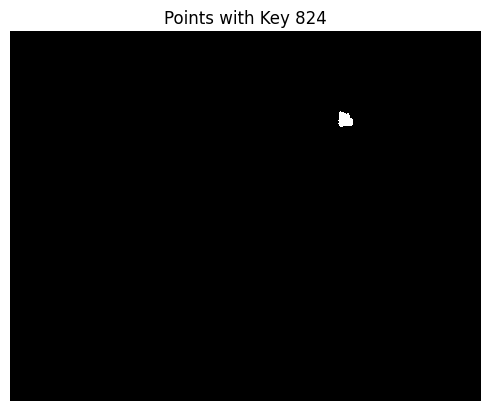

chair
(370, 471)
311


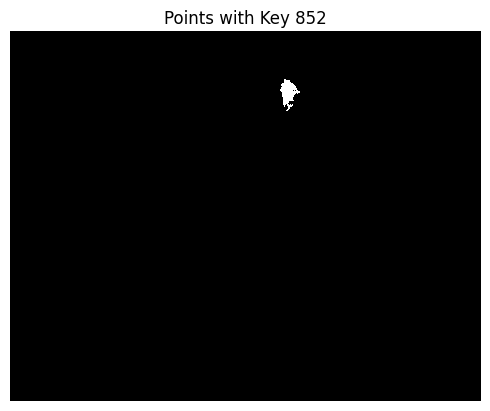

cabinet
(370, 471)
1777


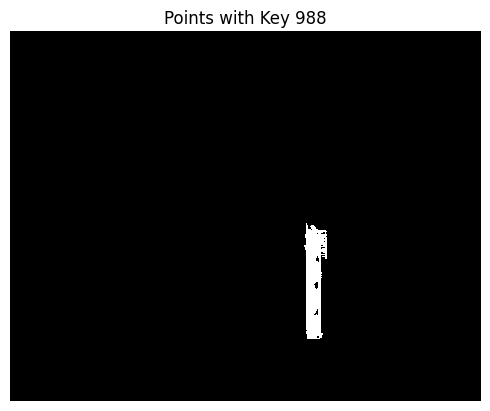

counter
(370, 471)
2979


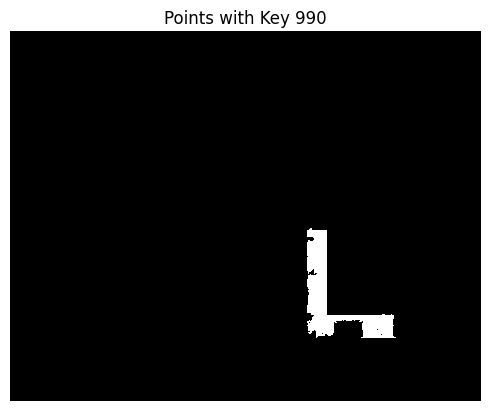

floor
(370, 471)
614


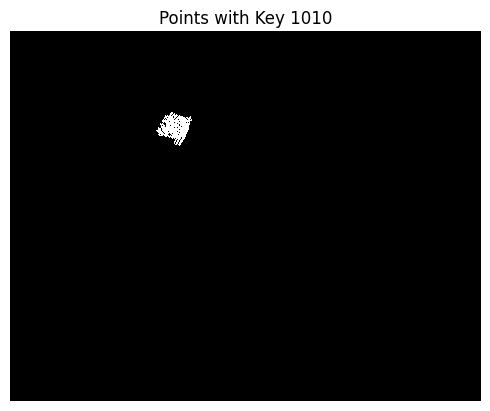

floor
(370, 471)
252


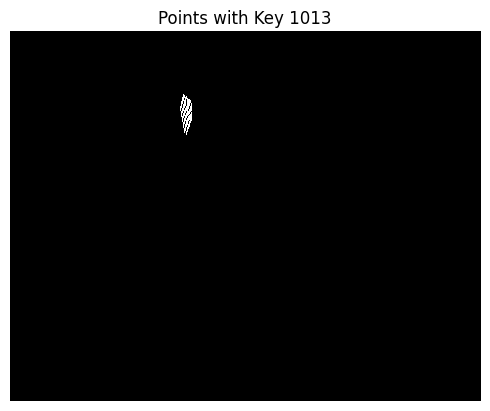

floor
(370, 471)
215


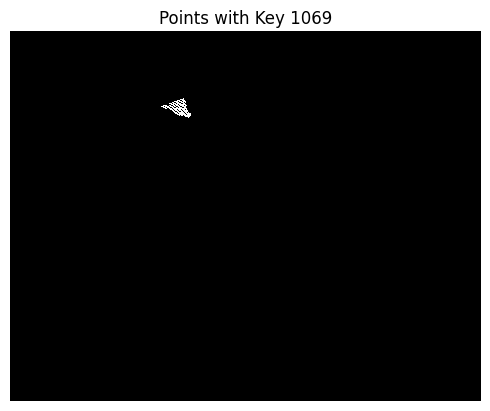

sink
(370, 471)
226


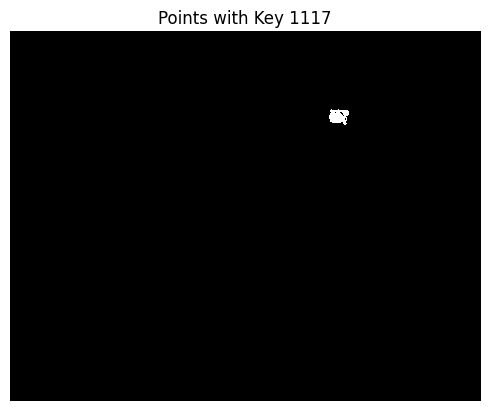

table
(370, 471)
169


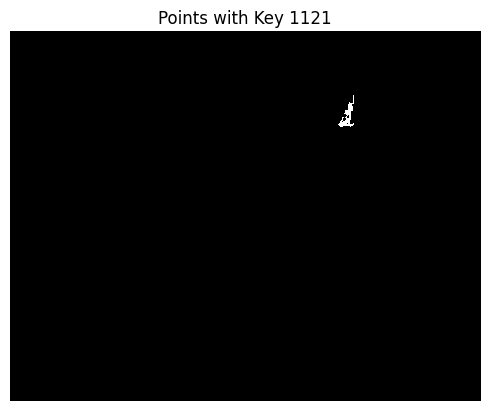

fireplace
(370, 471)
1607


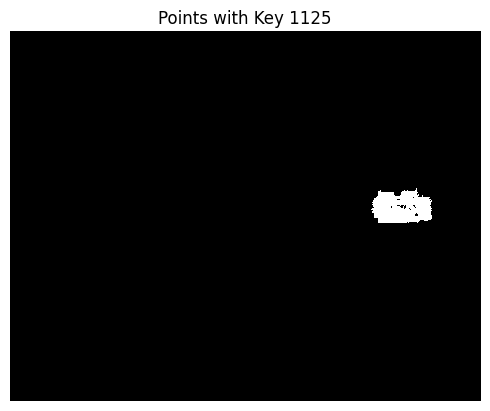

cabinet
(370, 471)
213


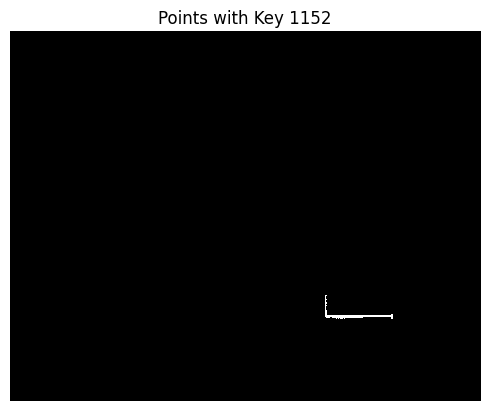

curtain
(370, 471)
316


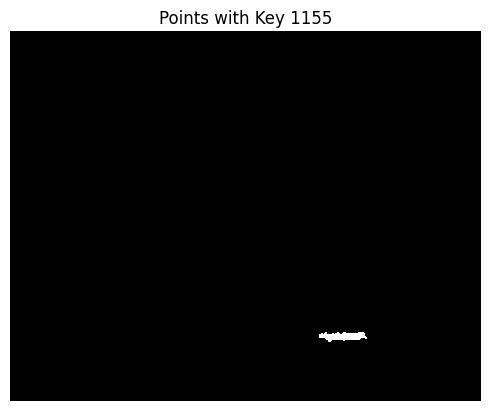

chair
(370, 471)
329


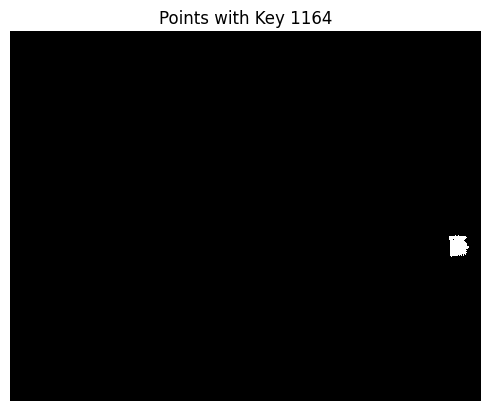

table
(370, 471)
114


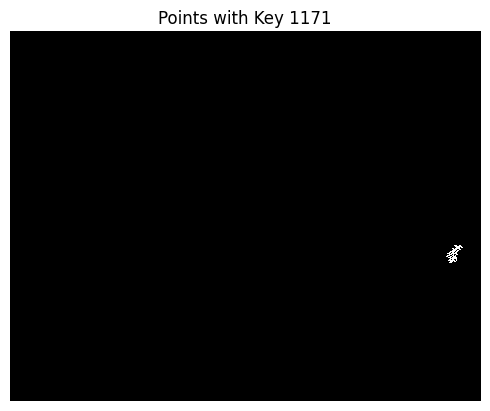

table
(370, 471)
1731


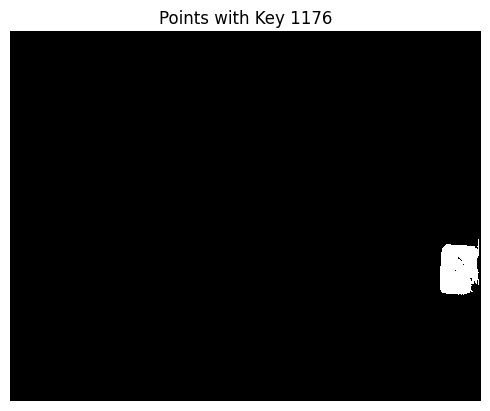

door
(370, 471)
267


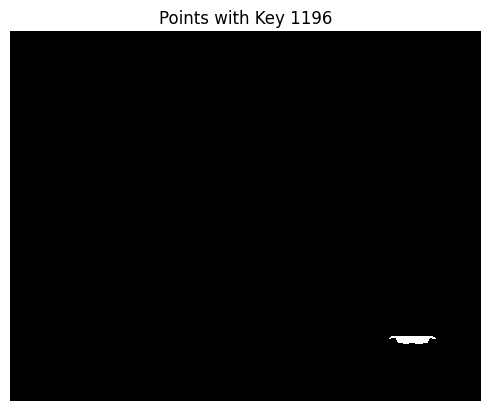

sink
(370, 471)
530


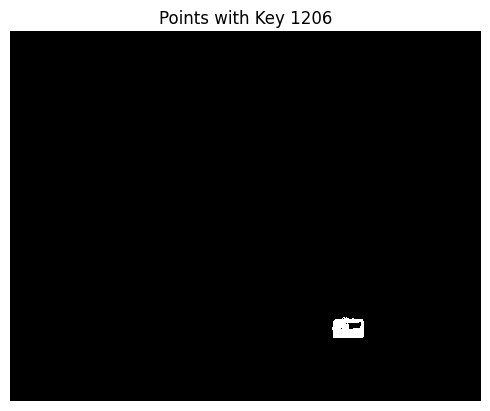

cabinet
(370, 471)
906


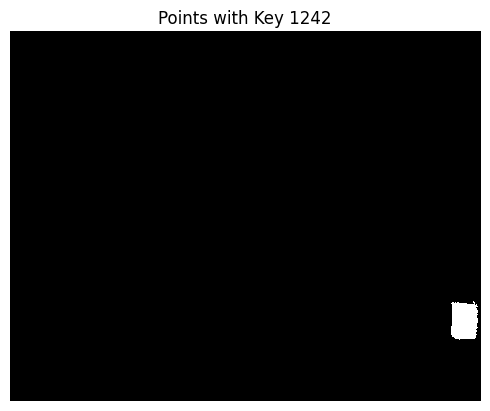

chair
(370, 471)
374


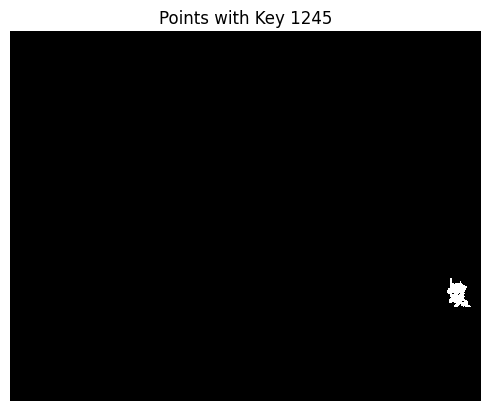

curtain
(370, 471)
348


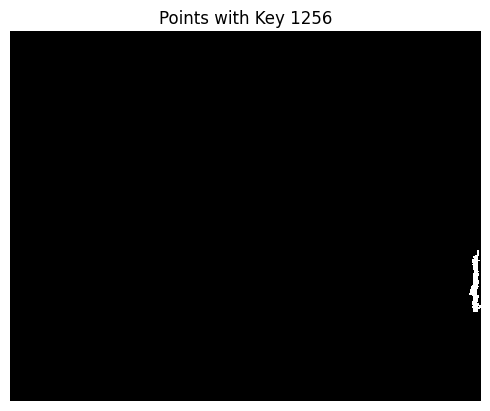

chair
(370, 471)
190


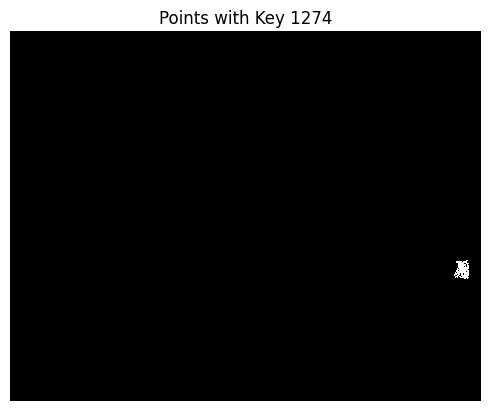

furniture
(370, 471)
141


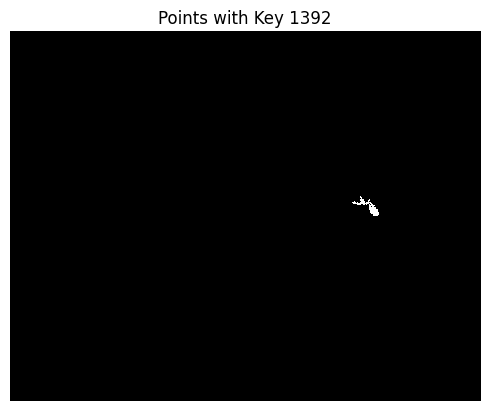

table
(370, 471)
105


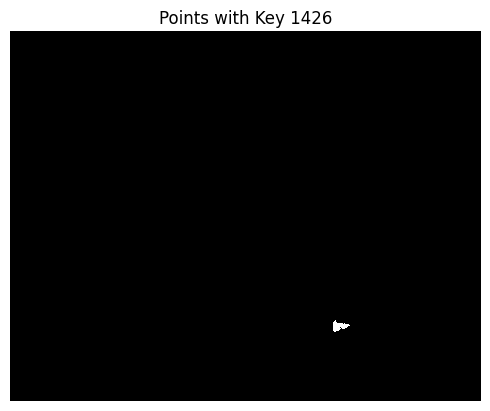

furniture
(370, 471)
272


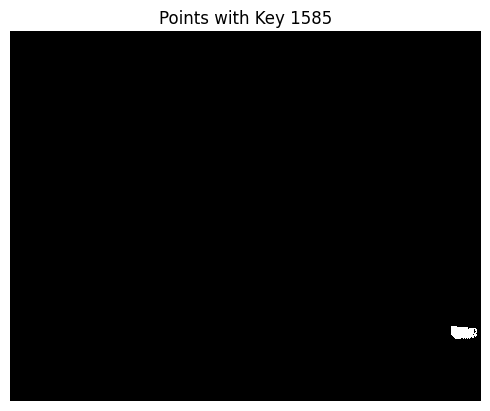

chair
(370, 471)
144


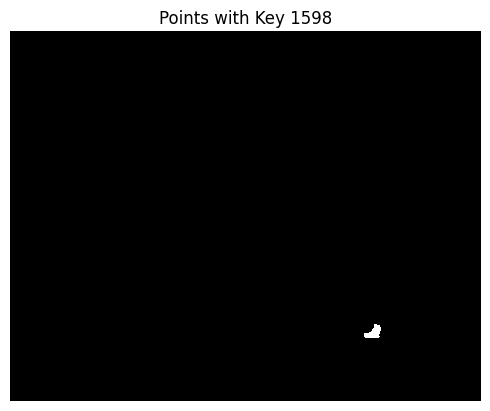

table
(370, 471)
136


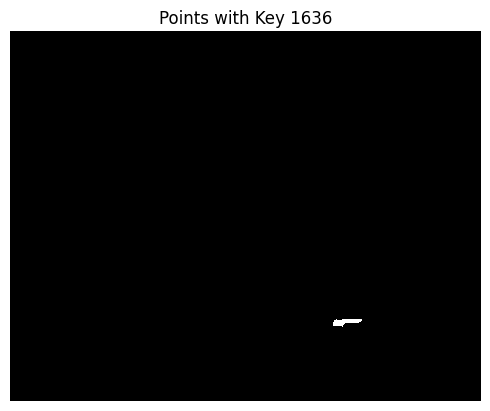

table
(370, 471)
112


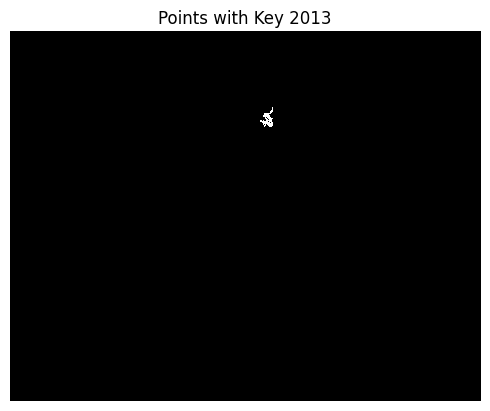

table
(370, 471)
105


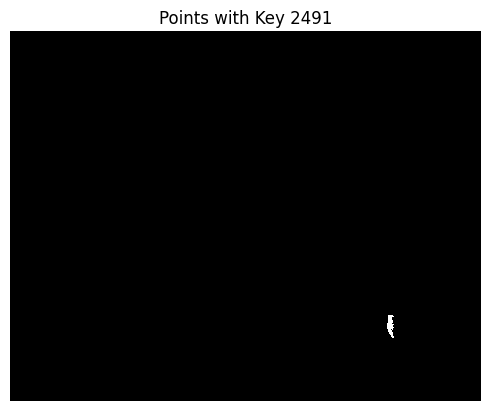

table
(370, 471)
212


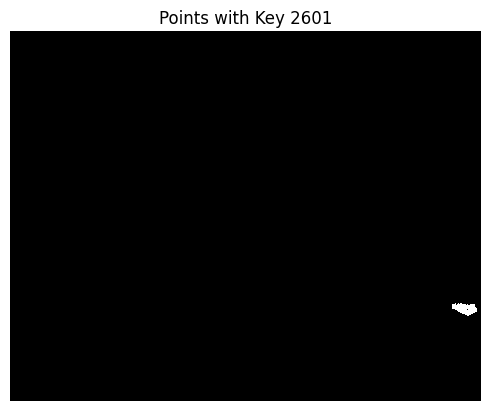

chair
(370, 471)
155


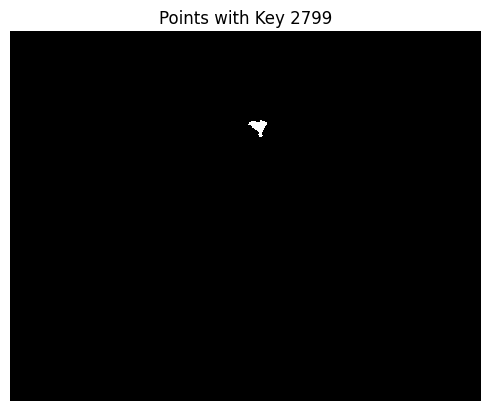

chair
(370, 471)
115


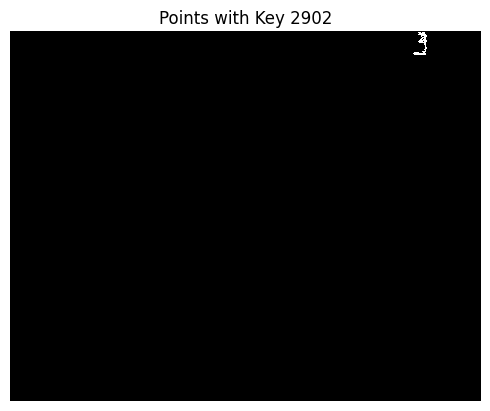

chair
(370, 471)
104


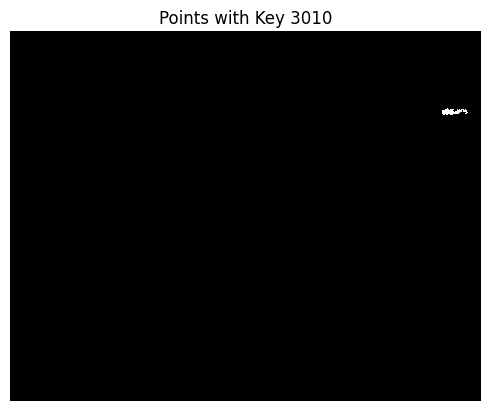

chair
(370, 471)
118


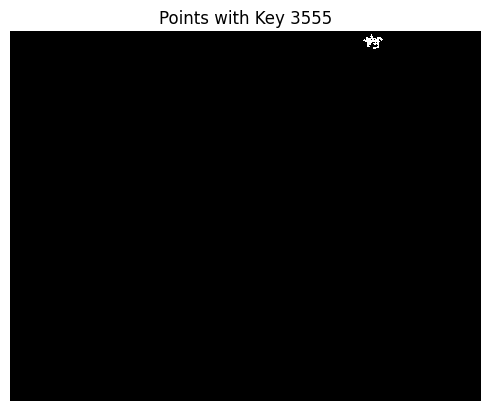

door
(370, 471)
111


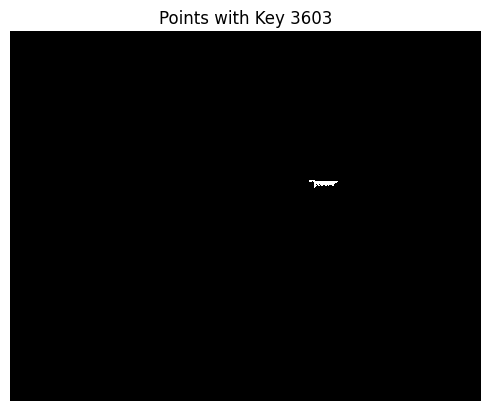

table
(370, 471)
177


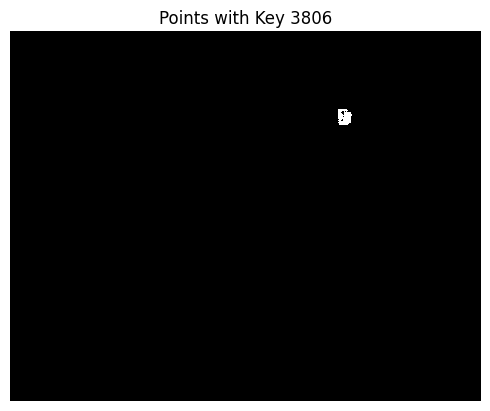

stairs
(370, 471)
110


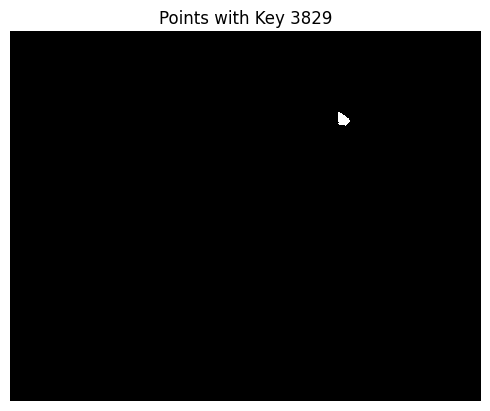

door
(370, 471)
271


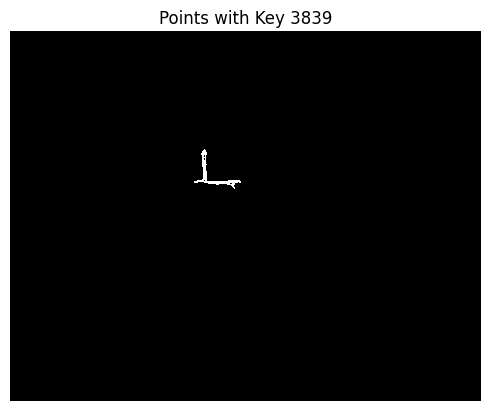

floor
(370, 471)
507


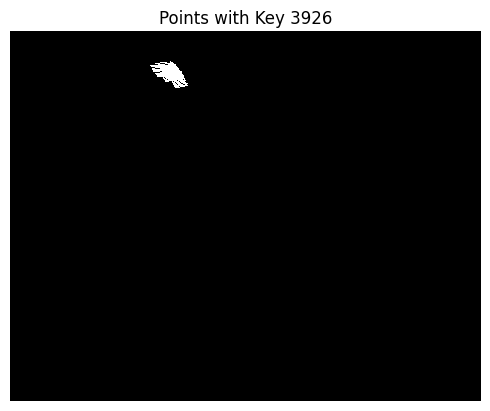

floor
(370, 471)
493


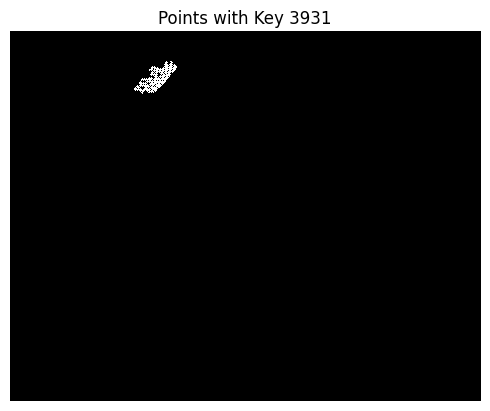

chest_of_drawers
(370, 471)
515


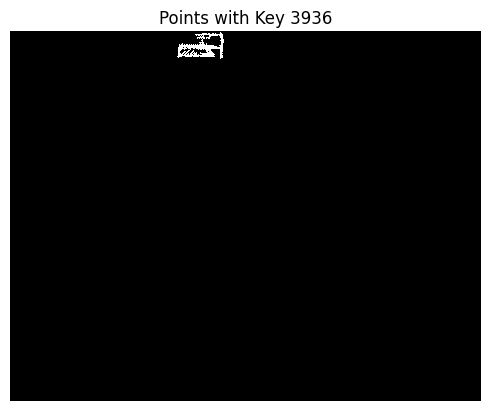

floor
(370, 471)
1187


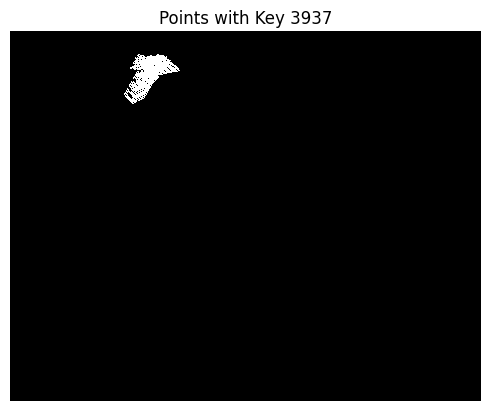

chair
(370, 471)
100


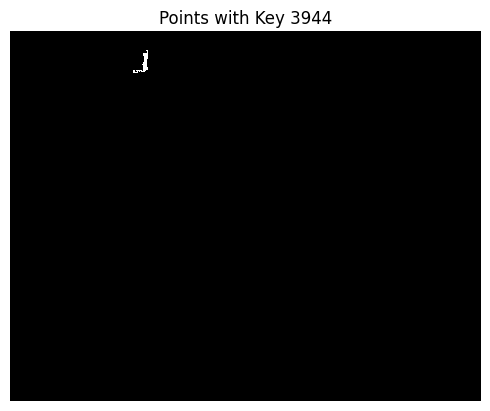

clothes
(370, 471)
444


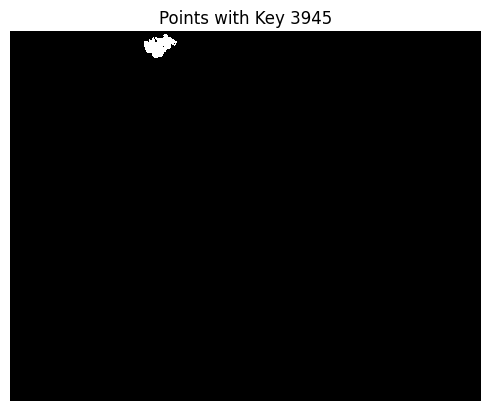

floor
(370, 471)
1124


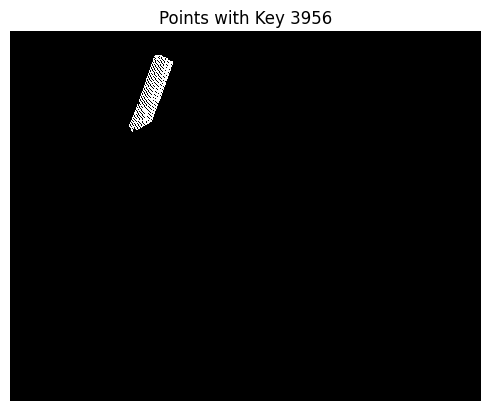

floor
(370, 471)
743


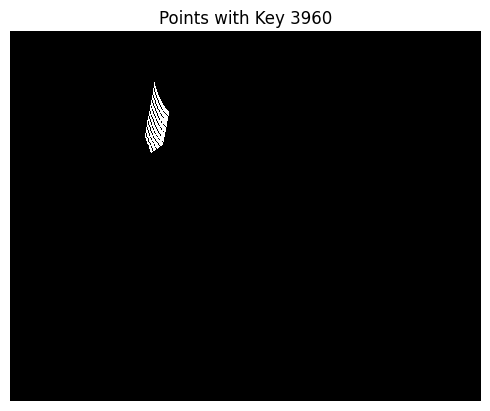

cabinet
(370, 471)
687


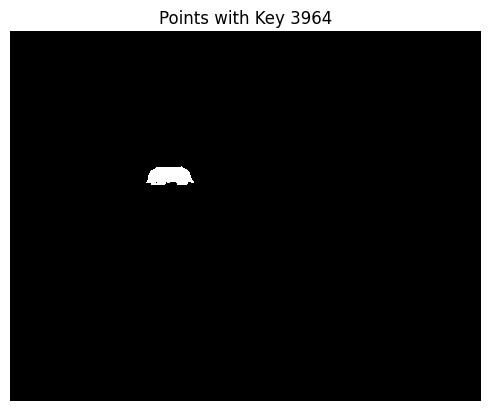

floor
(370, 471)
541


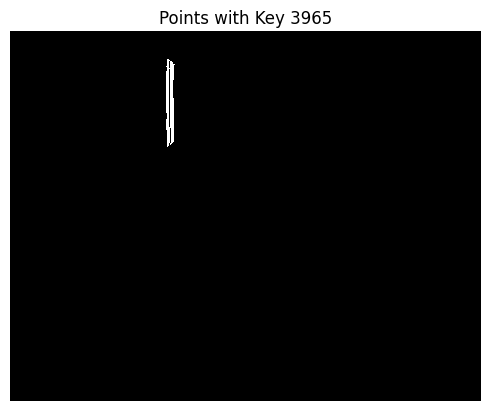

floor
(370, 471)
4998


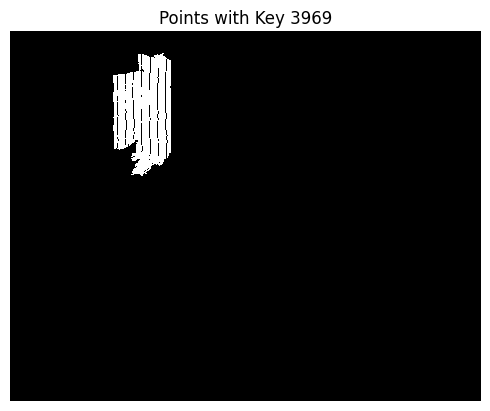

chair
(370, 471)
725


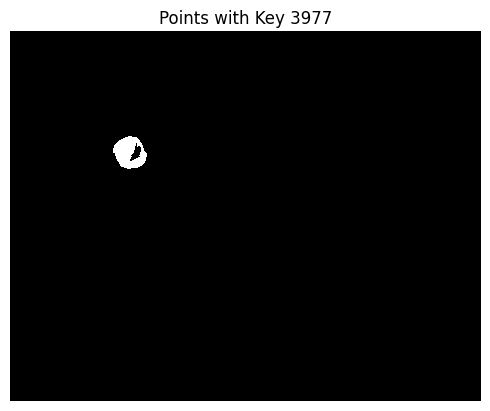

sofa
(370, 471)
190


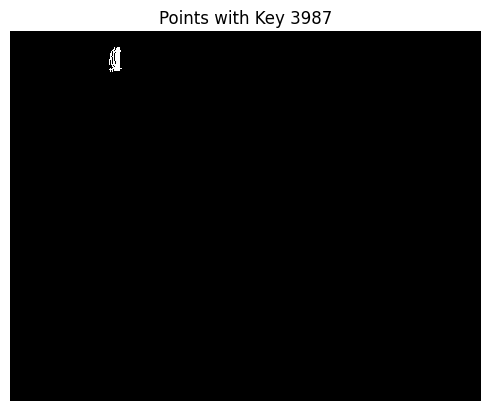

sofa
(370, 471)
382


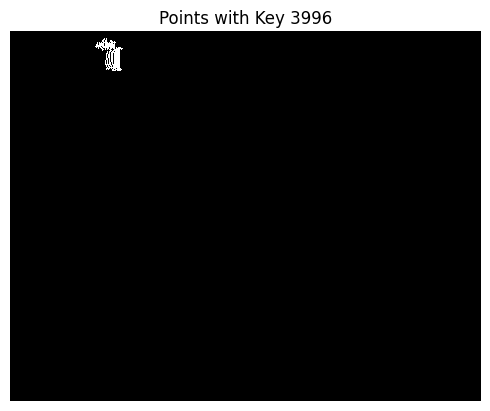

floor
(370, 471)
7808


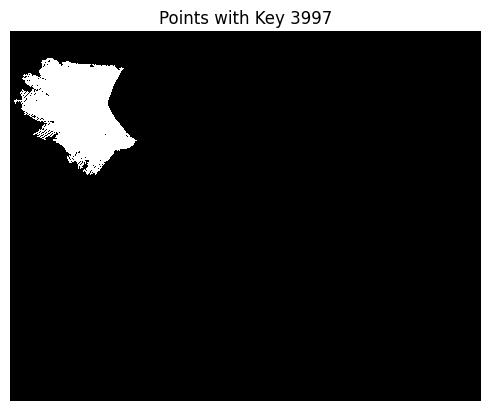

chair
(370, 471)
2982


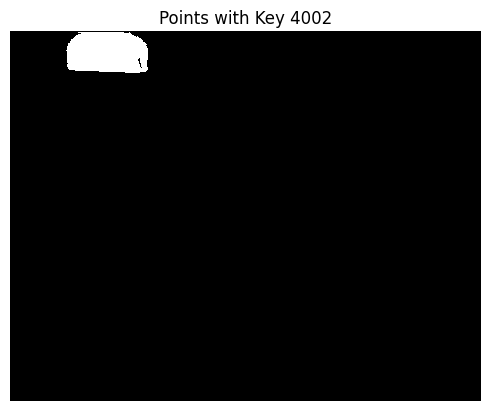

table
(370, 471)
405


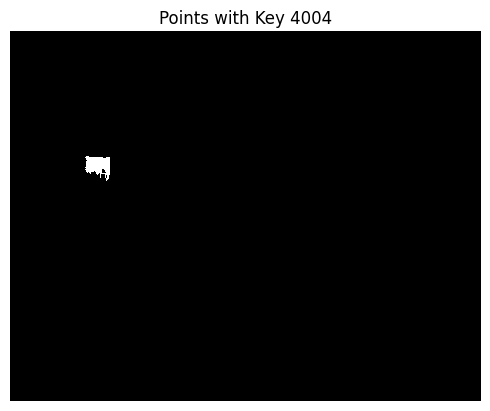

plant
(370, 471)
678


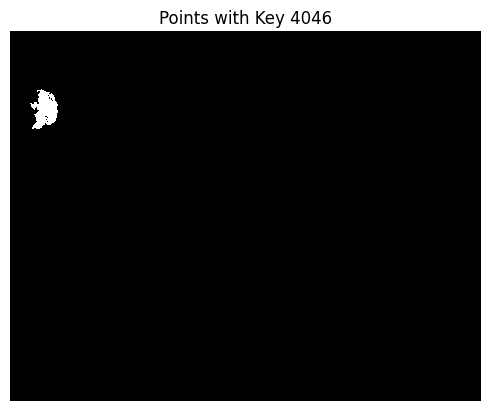

chair
(370, 471)
1159


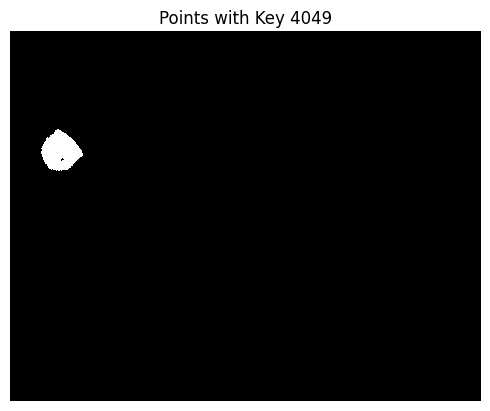

chair
(370, 471)
400


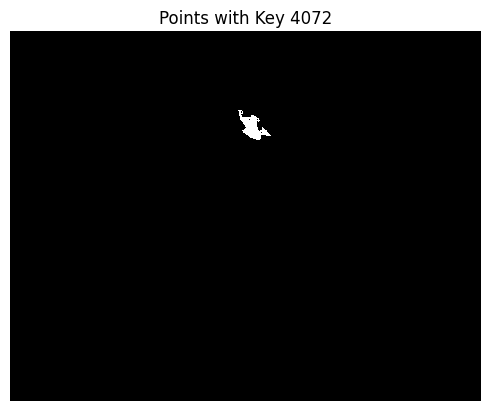

chest_of_drawers
(370, 471)
147


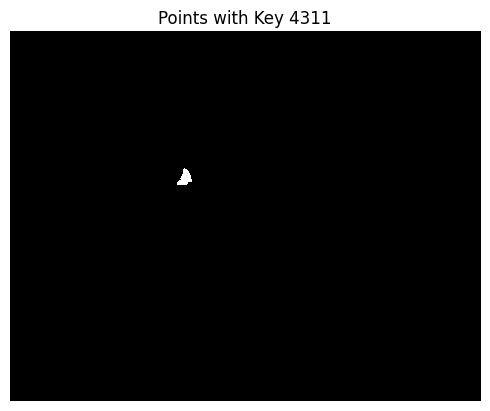

lighting
(370, 471)
170


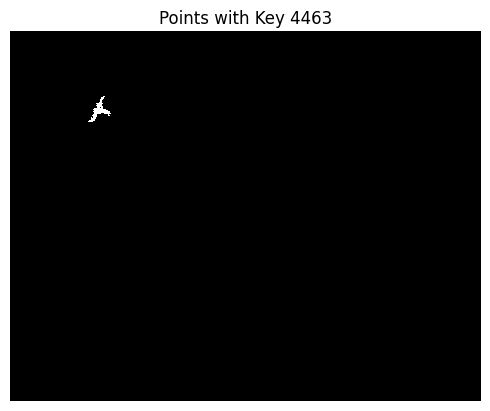

chest_of_drawers
(370, 471)
165


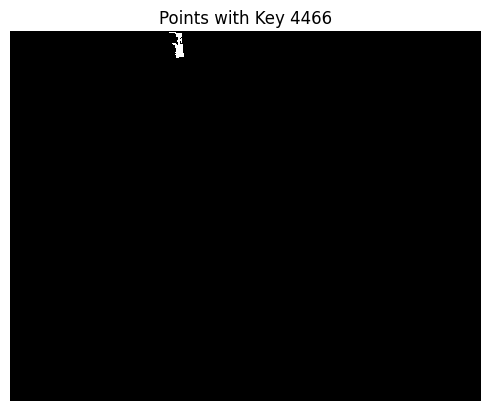

chair
(370, 471)
634


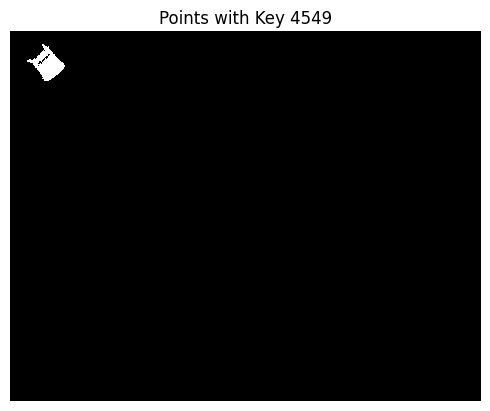

window
(370, 471)
140


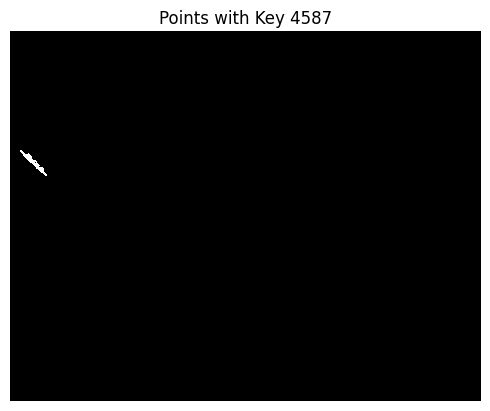

table
(370, 471)
173


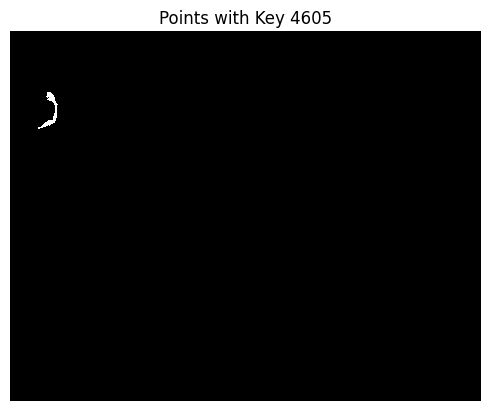

window
(370, 471)
116


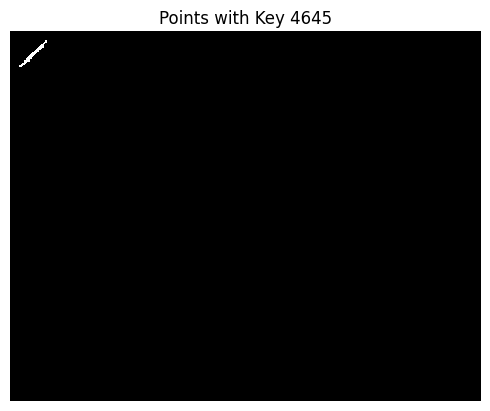

window
(370, 471)
160


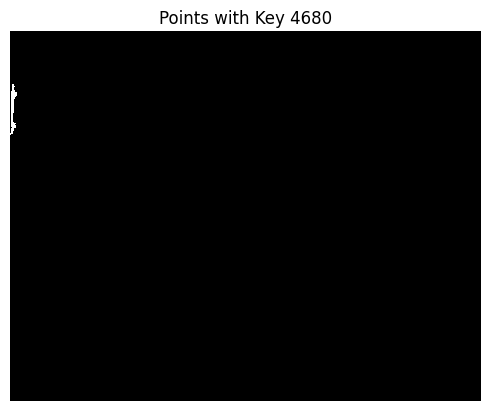

chair
(370, 471)
223


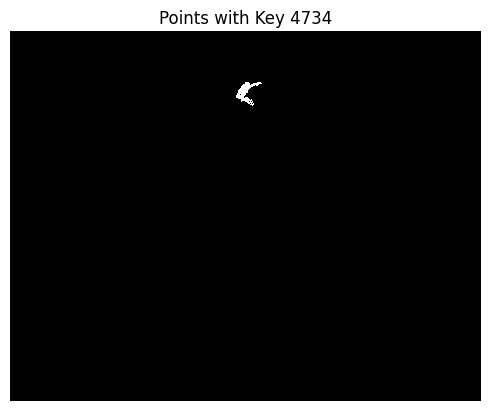

table
(370, 471)
104


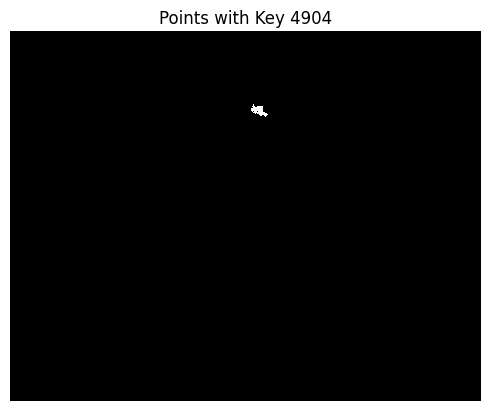

bed
(370, 471)
701


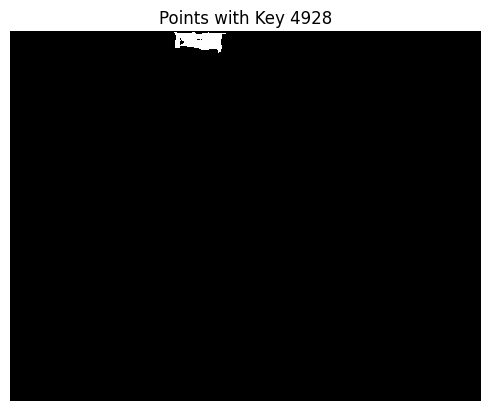

chair
(370, 471)
164


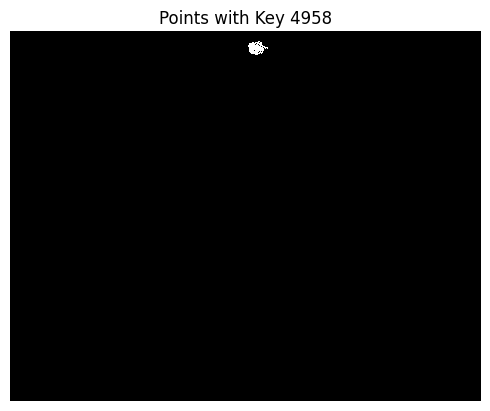

fireplace
(370, 471)
212


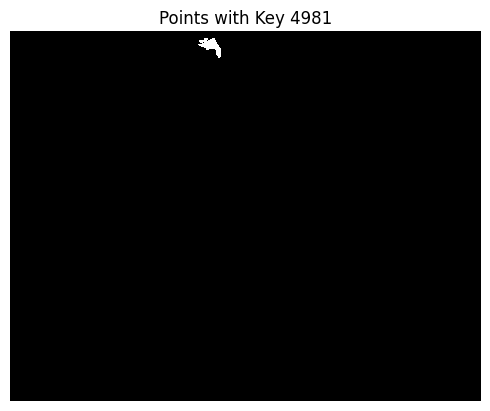

door
(370, 471)
443


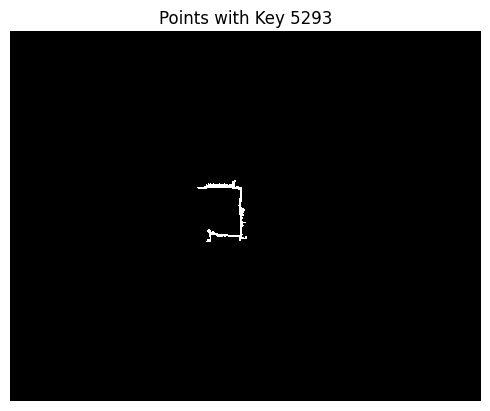

chest_of_drawers
(370, 471)
125


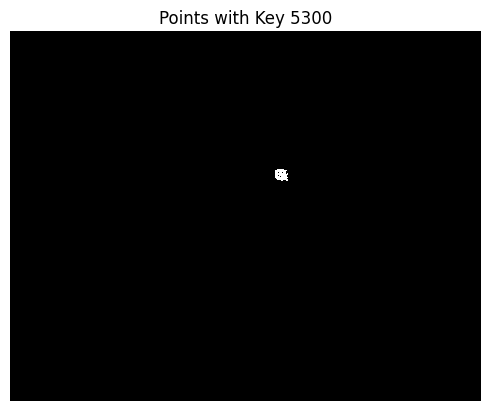

cabinet
(370, 471)
487


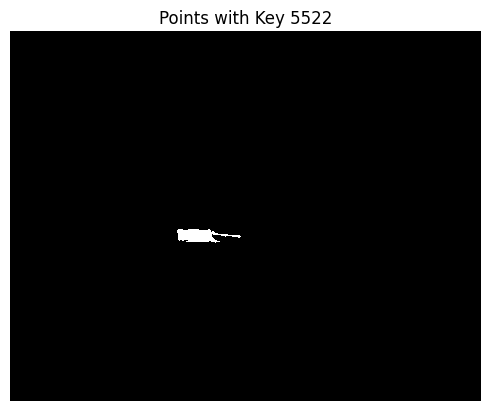

door
(370, 471)
581


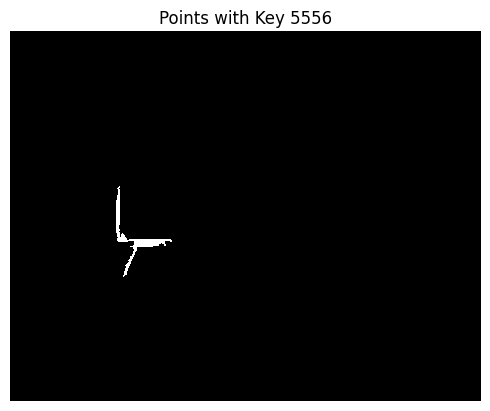

sink
(370, 471)
461


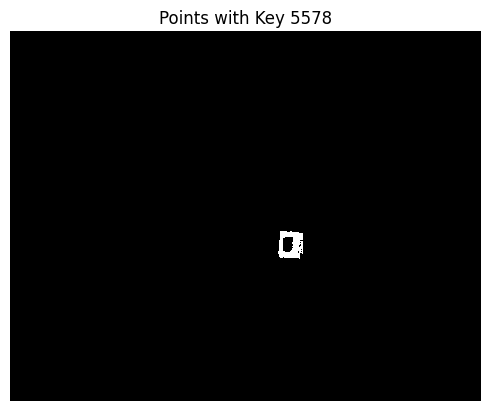

chair
(370, 471)
391


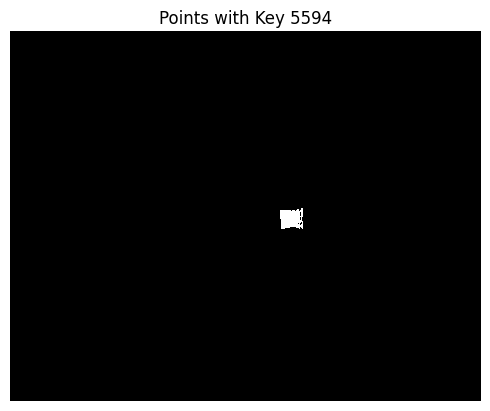

cabinet
(370, 471)
261


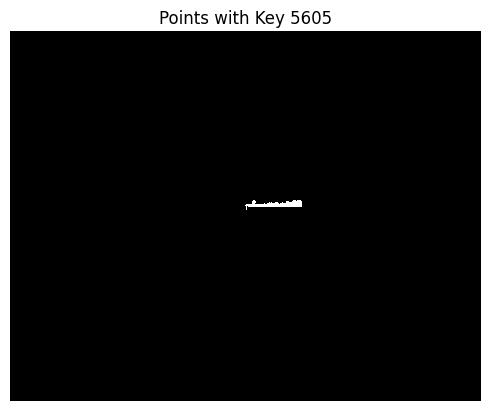

counter
(370, 471)
901


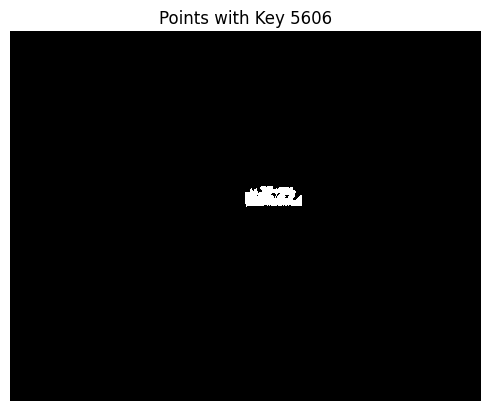

bathtub
(370, 471)
742


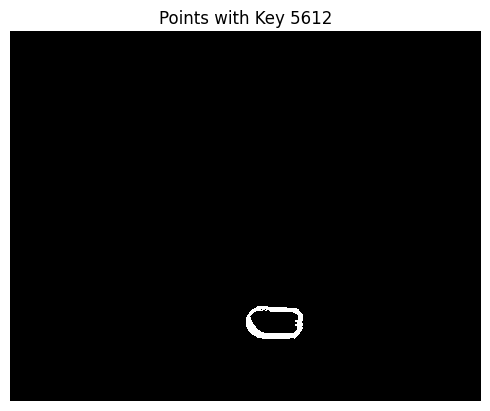

chest_of_drawers
(370, 471)
183


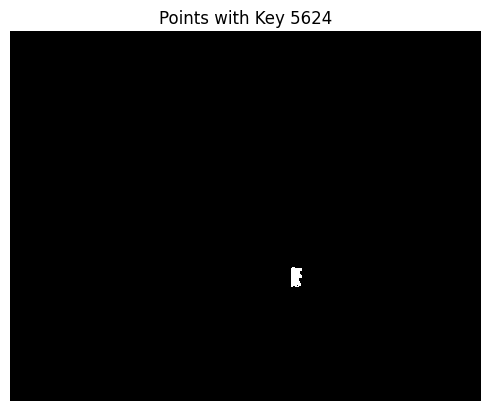

curtain
(370, 471)
233


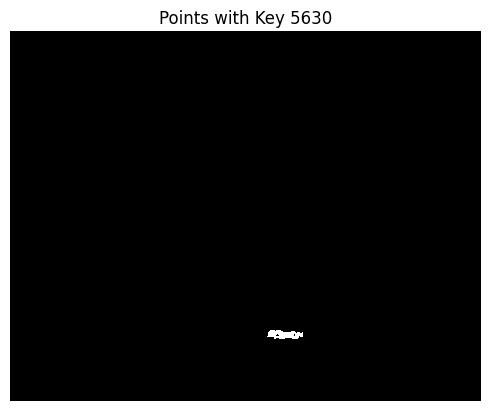

table
(370, 471)
321


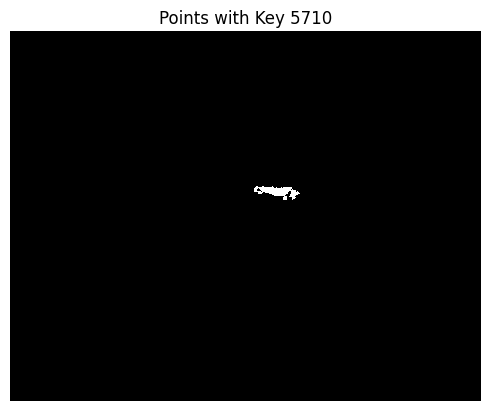

towel
(370, 471)
123


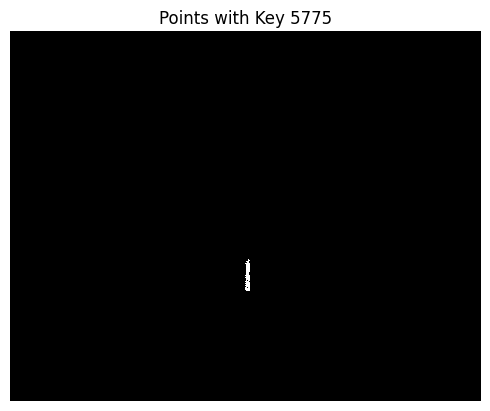

floor
(370, 471)
666


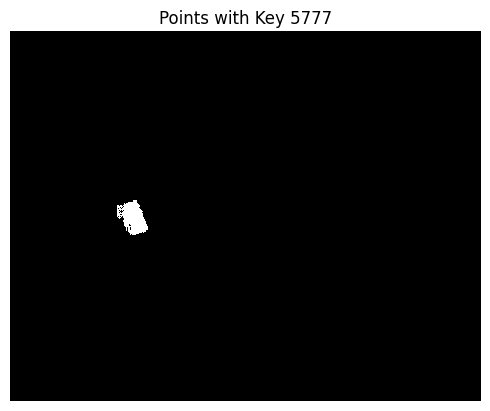

bed
(370, 471)
212


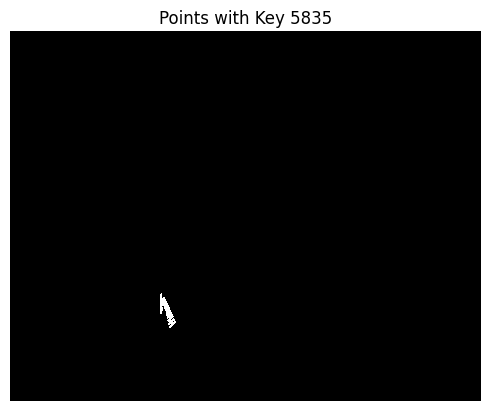

bed
(370, 471)
4428


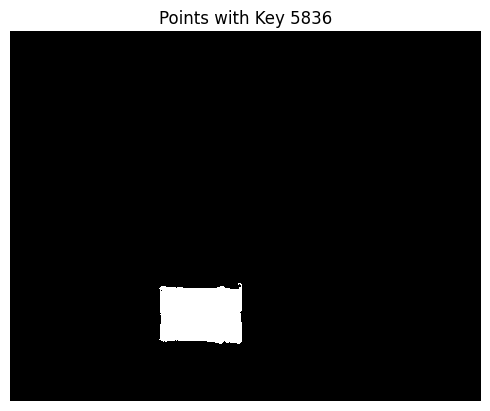

floor
(370, 471)
241


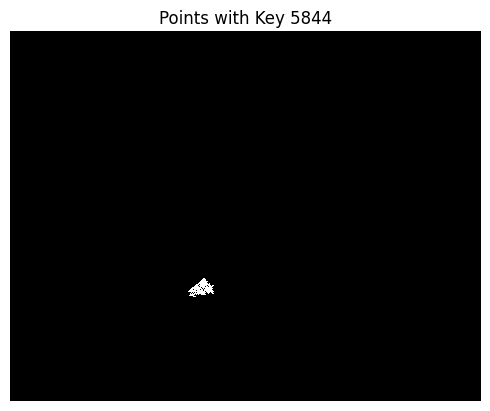

floor
(370, 471)
726


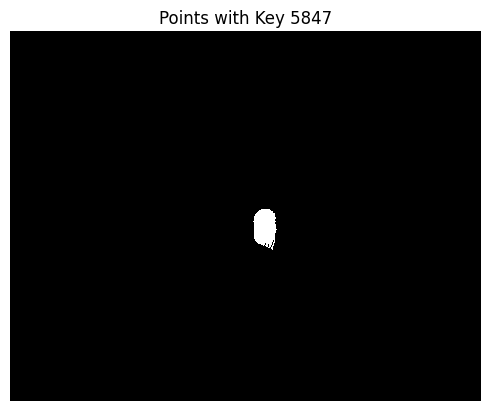

floor
(370, 471)
448


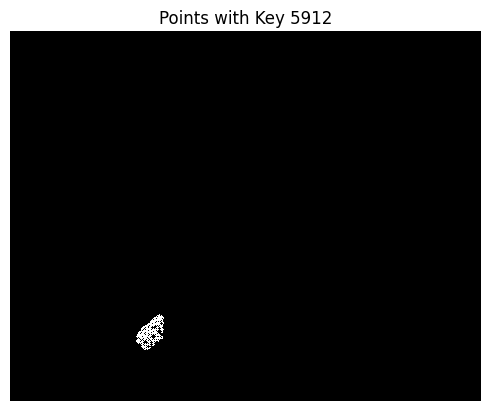

floor
(370, 471)
238


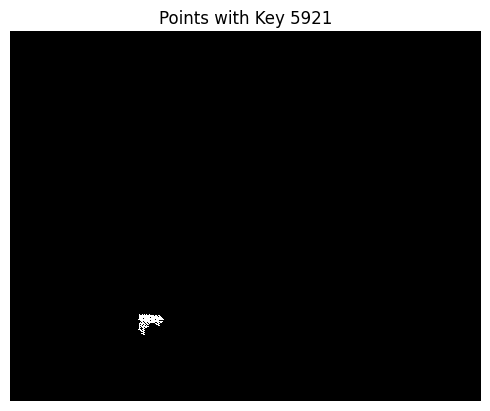

chair
(370, 471)
490


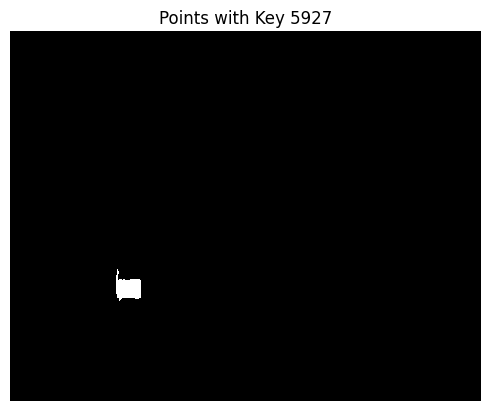

curtain
(370, 471)
196


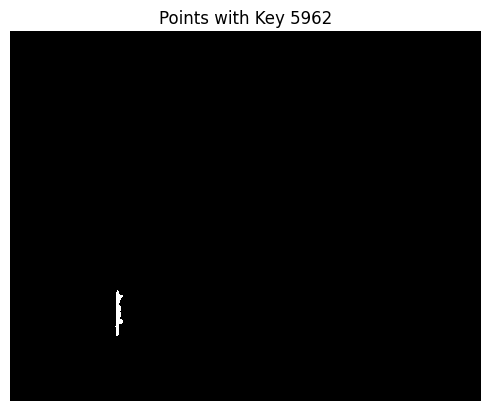

chest_of_drawers
(370, 471)
1613


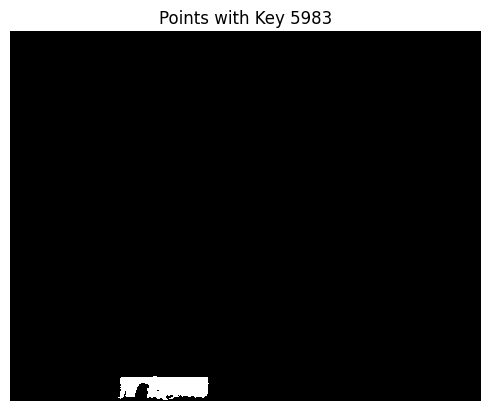

curtain
(370, 471)
205


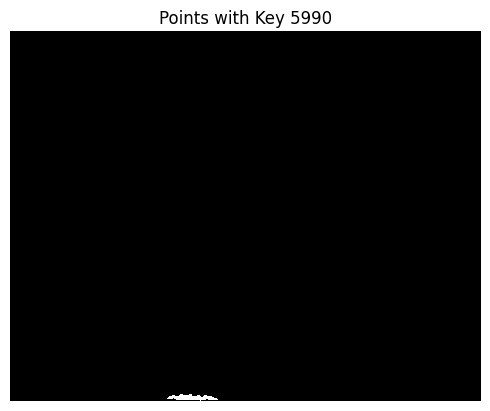

chair
(370, 471)
377


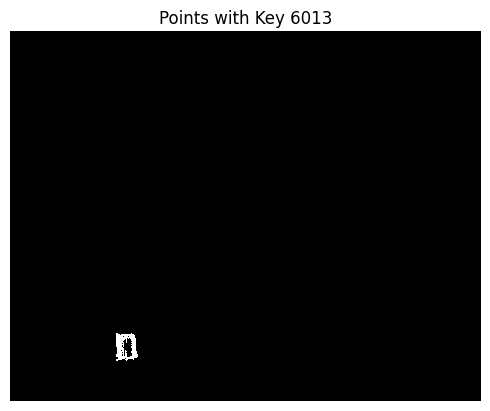

chest_of_drawers
(370, 471)
697


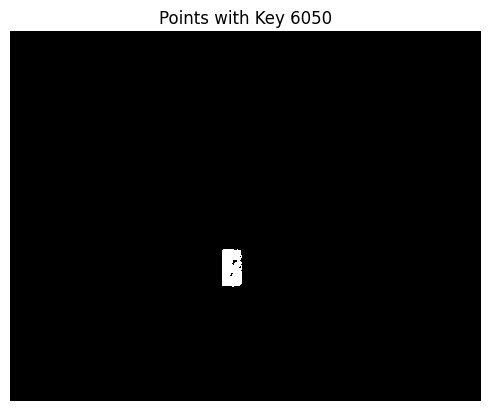

chair
(370, 471)
363


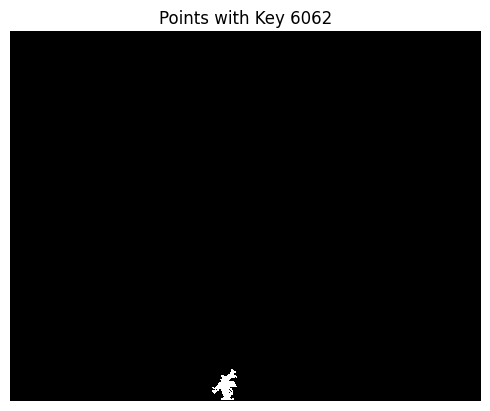

floor
(370, 471)
132


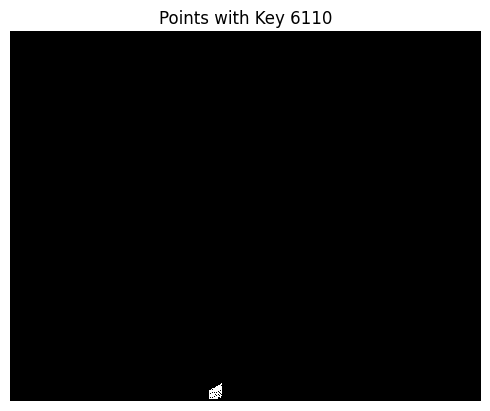

floor
(370, 471)
212


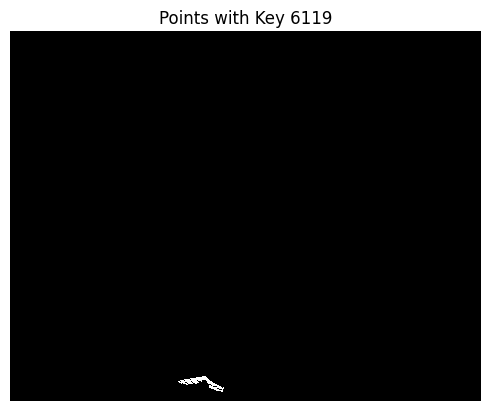

floor
(370, 471)
1051


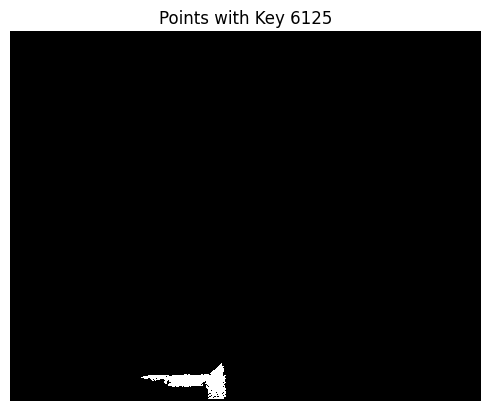

chest_of_drawers
(370, 471)
173


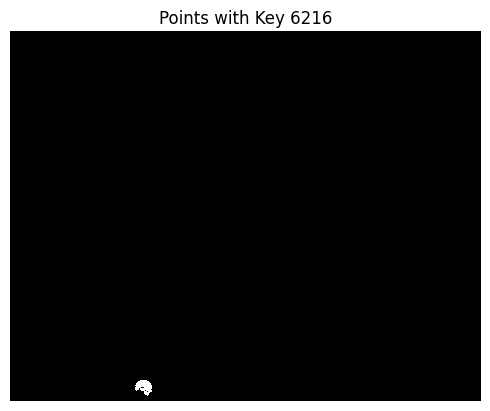

door
(370, 471)
144


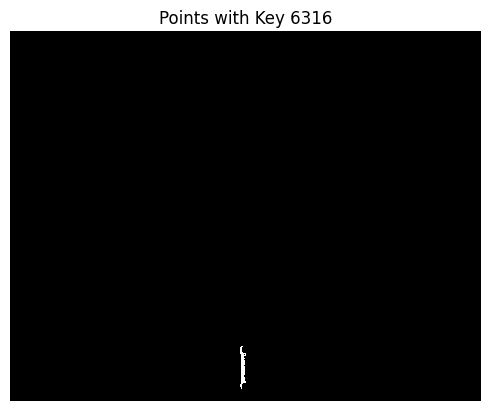

curtain
(370, 471)
147


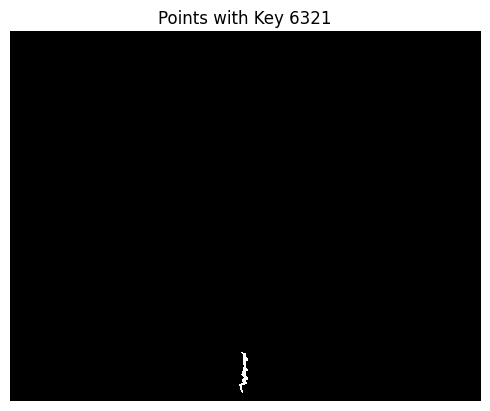

chest_of_drawers
(370, 471)
112


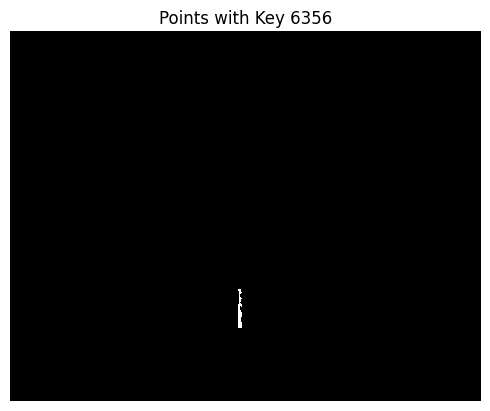

floor
(370, 471)
189


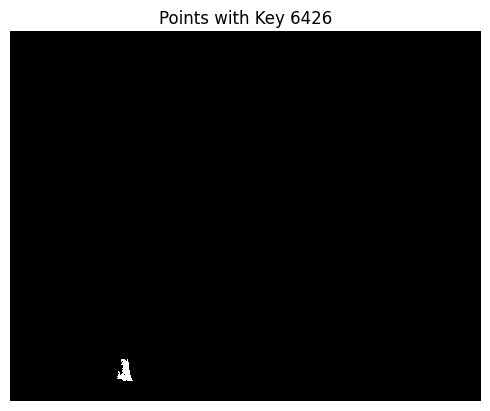

chair
(370, 471)
101


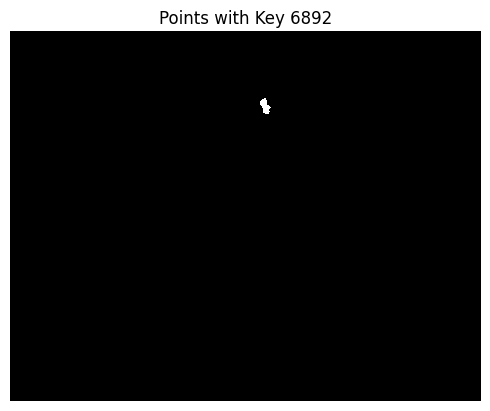

stool
(370, 471)
115


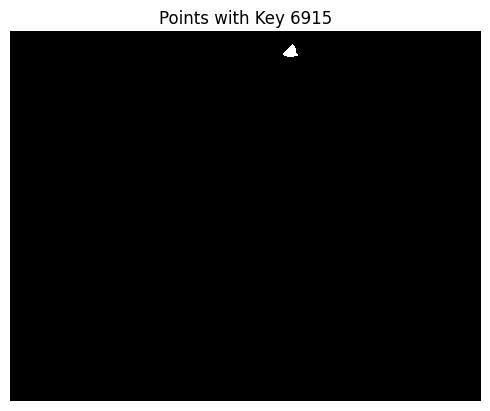

floor
(370, 471)
211


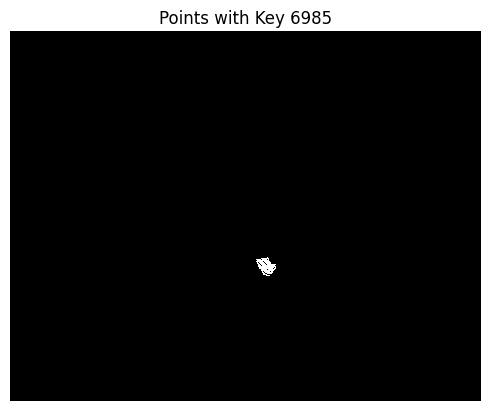

toilet
(370, 471)
195


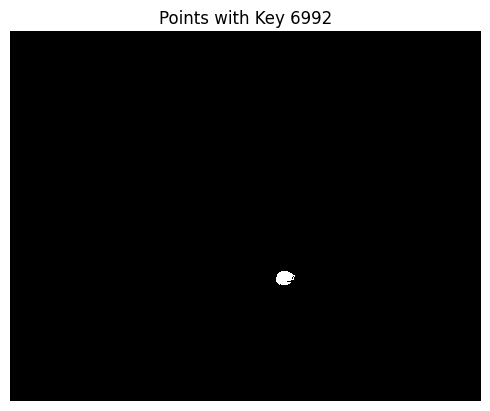

floor
(370, 471)
925


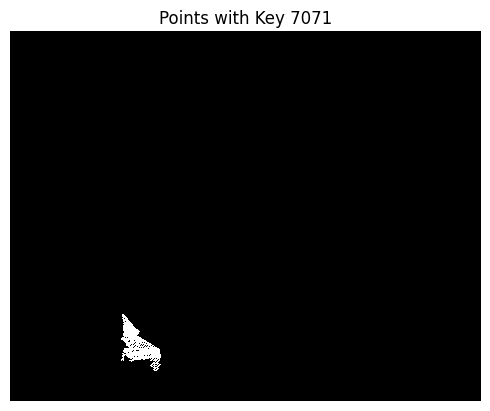

floor
(370, 471)
455


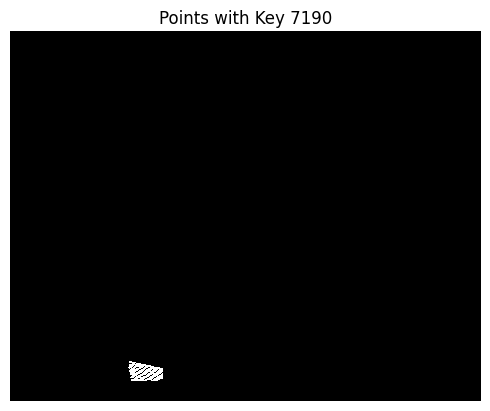

floor
(370, 471)
346


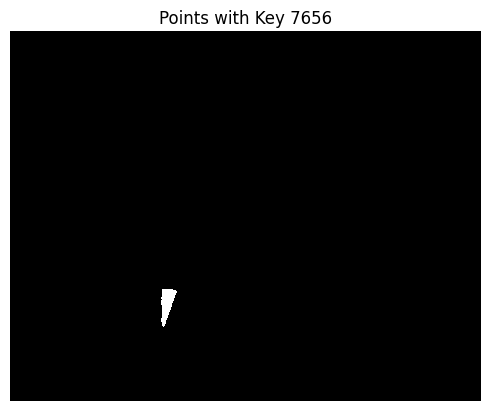

bed
(370, 471)
129


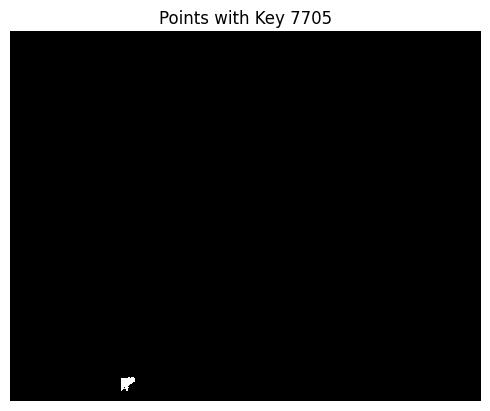

bed
(370, 471)
464


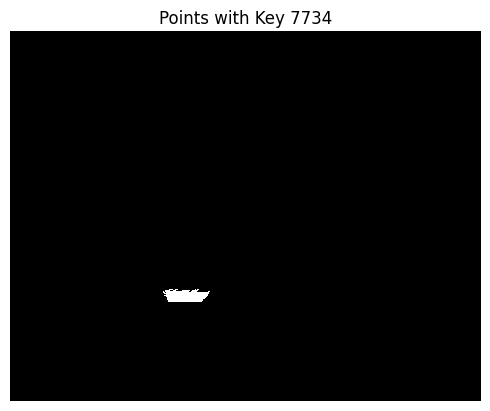

bed
(370, 471)
129


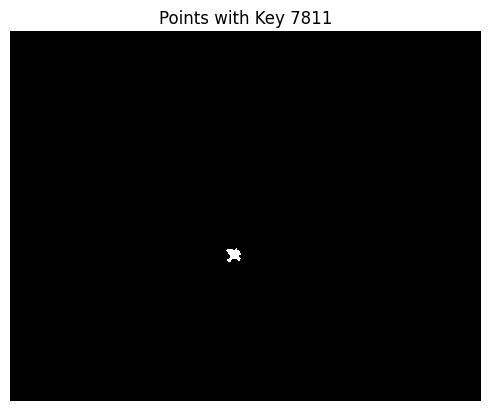

In [16]:
# # 좌표에 0이 키값으로 있는 포인트만 선택하여 ggrid_map 생성
# ggrid_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
# for i in range(grid.shape[0]):
#     for j in range(grid.shape[1]):
#         if 5 in grid[i, j]:
#             ggrid_map[i, j] = 1  # 0 키를 가진 포인트는 1로 표시

# # 시각화를 위해 1이 있는 곳만 표시
# plt.figure(figsize=(10, 6), dpi=120)
# plt.imshow(ggrid_map, cmap="gray")
# plt.axis('off')
# plt.title("Points with Key 0")
# plt.show()

import numpy as np
import matplotlib.pyplot as plt

# 시각화를 위한 설정
plt.figure(figsize=(10, 6), dpi=120)
print(embeddings.keys())
# k값을 0부터 287까지 변경하면서 시각화
for n,id in enumerate(embeddings.keys()):
    # 좌표에 k가 키값으로 있는 포인트만 선택하여 ggrid_map 생성
    ggrid_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if id in grid[i, j]:
                ggrid_map[i, j] = 1  # k 키를 가진 포인트는 1로 표시
    # maskk = embeddings[id]["mask"]
    # print(maskk.shape)
    # print(np.sum(maskk))
    # # 시각화를 위해 1이 있는 곳만 표시
    # plt.clf()  # 이전 이미지 지우기
    # plt.imshow(maskk, cmap="gray")

    plt.clf()  # 이전 이미지 지우기
    name = predicts[n]
    print(query[name])
    print(ggrid_map.shape)
    print(np.sum(ggrid_map))
    plt.imshow(ggrid_map, cmap="gray")


    plt.axis('off')
    plt.title(f"Points with Key {id}")
    plt.draw()  # 현재 상태를 그리기
    plt.pause(0.5)  # 0.5초 간격으로 업데이트 (시간 조정 가능)

    plt.show()
